In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
listAttributesRAPv2 = ['hs-BaldHead', 'hs-LongHair', 'hs-BlackHair', 'hs-Hat', 'hs-Glasses','ub-Shirt','ub-Sweater','ub-Vest','ub-TShirt','ub-Cotton','ub-Jacket','ub-SuitUp','ub-Tight','ub-ShortSleeve','ub-Others','lb-LongTrousers','lb-Skirt','lb-ShortSkirt','lb-Dress','lb-Jeans','lb-TightTrousers','shoes-Leather', 'shoes-Sports', 'shoes-Boots', 'shoes-Cloth', 'shoes-Casual', 'shoes-Other','attachment-Backpack','attachment-ShoulderBag','attachment-HandBag','attachment-Box','attachment-PlasticBag','attachment-PaperBag','attachment-HandTrunk','attachment-Other','AgeLess16', 'Age17-30', 'Age31-45', 'Age46-60','Female','BodyFat','BodyNormal','BodyThin','Customer','Employee','action-Calling','action-Talking','action-Gathering','action-Holding','action-Pushing','action-Pulling','action-CarryingByArm','action-CarryingByHand','action-Other']
listAttributesRAPzs = listAttributesRAPv2

listAttributesRAPzs.remove('Age46-60')

columnsDF = ['value F1', 'nameImg']
columnsDF.extend(listAttributesRAPzs)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


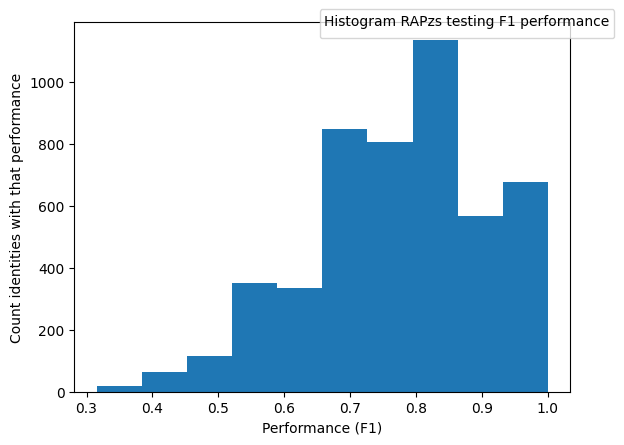

<Figure size 640x480 with 0 Axes>

In [3]:
pathToTestingMetricF1 = 'RAPzs/testing_dict_instance_f1.json'
pathToTestingDataGTPredicted = 'RAPzs/testing_dict_gt_predicted.json'

pathToSaveComplexIdentities = 'RAPzs/'

fileTestingGTPredicted = open(pathToTestingDataGTPredicted)
jsonTestingGTPredicted = json.load(fileTestingGTPredicted)


fileTestingMetricF1 = open(pathToTestingMetricF1)
jsonTestingMetricF1 = json.load(fileTestingMetricF1)

values = jsonTestingMetricF1['testing f1']

listNames = []
for list in jsonTestingMetricF1['img name testing']:
    for item in list:
        listNames.append(item)

dfTestingRAPzs = pd.DataFrame()
dfTestingRAPzs['values'] = values
dfTestingRAPzs['name'] = listNames

plt.hist(dfTestingRAPzs['values'])
plt.xlabel('Performance (F1)')
plt.ylabel('Count identities with that performance')
tittle='Histogram RAPzs testing F1 performance'
plt.legend(bbox_to_anchor=(1.1, 1.05), title=tittle, fontsize='small', fancybox=True)
plt.show()
plt.savefig(pathToSaveComplexIdentities+'plotHistogramTestingIdentities.pdf')

In [4]:
maxIdentities = -1
pd.options.display.max_colwidth = 100
medium = 0.4
best = 0.85
listNameValueWorstTesting = dfTestingRAPzs[dfTestingRAPzs['values']<medium][0:]['values'].tolist()
listNameImgWorstTesting = dfTestingRAPzs[dfTestingRAPzs['values']<medium][0:]['name'].tolist()
listNameIndexWorstTesting = dfTestingRAPzs[dfTestingRAPzs['values']<medium][0:].index.tolist()

listNameValueMediumTesting = dfTestingRAPzs[(dfTestingRAPzs['values']<best) & (dfTestingRAPzs['values']>=medium)][0:]['values'].tolist()
listNameImgMediumTesting = dfTestingRAPzs[(dfTestingRAPzs['values']<best) & (dfTestingRAPzs['values']>=medium)][0:]['name'].tolist()
listNameIndexMediumTesting = dfTestingRAPzs[(dfTestingRAPzs['values']<best) & (dfTestingRAPzs['values']>=medium)][0:].index.tolist()

listNameValueBestTesting = dfTestingRAPzs[dfTestingRAPzs['values']>best][0:]['values'].tolist()
listNameImgBestTesting = dfTestingRAPzs[dfTestingRAPzs['values']>best][0:]['name'].tolist()
listNameIndexBestTesting = dfTestingRAPzs[dfTestingRAPzs['values']>best][0:].index.tolist()

valuesGTTesting = jsonTestingGTPredicted['testing gt']
valuesPredictedTestingOld = jsonTestingGTPredicted['testing predicted']
valuesPredictedTesting = []
for vector in valuesPredictedTestingOld:
    newVector = []
    for value in vector:
        newVector.append(value)
    valuesPredictedTesting.append(newVector)

In [5]:
dfTestingWorst = pd.DataFrame(columns=columnsDF)
for name, index in zip(listNameImgWorstTesting, listNameIndexWorstTesting):
    value = listNameValueWorstTesting[listNameImgWorstTesting.index(name)]
    xnorRow = [value, name]

    diffGTPredicted = [(gt - predicted) for gt, predicted in zip(valuesGTTesting[index], valuesPredictedTesting[index])]
    
    # this row is the difference between the gt and the predicted
    xnorRow.extend(diffGTPredicted)
    #xnorRow.extend(fillList)

    dfTestingWorst.loc[-1] = xnorRow
    dfTestingWorst.index = dfTestingWorst.index + 1
    dfTestingWorst = dfTestingWorst.sort_index()


dfAppearsTestingWorst = dfTestingWorst[listAttributesRAPzs].apply(pd.value_counts).fillna(0)
valuesAppearTestingWorst = {}
for i, row in dfAppearsTestingWorst.iterrows():
    valuesAppearTestingWorst[i] = row.values.tolist()


In [6]:
def plotHowAttributesAreWorking(columns,valuesAppear, tittleGraph, tittleLegend):

    x = np.arange(len(columns))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=(30, 15))

    for attribute, measurement in valuesAppear.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute, log=True)
        ax.bar_label(rects, padding=5)
        multiplier += 1

    labels=['-1.0 - False Positive', '0.0 - model predicts well', '1.0 - False Negative']

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Count')
    tittleGraph = tittleGraph
    ax.set_title(tittleGraph)
    ax.set_xticks(x + width, columns, rotation='vertical')
    tittleLegend = tittleLegend
    ax.legend(labels=labels, bbox_to_anchor=(1.1, 1.05), title=tittleLegend, fontsize='small', fancybox=True)
    #ax.set_ylim(0, 250)

    plt.show()

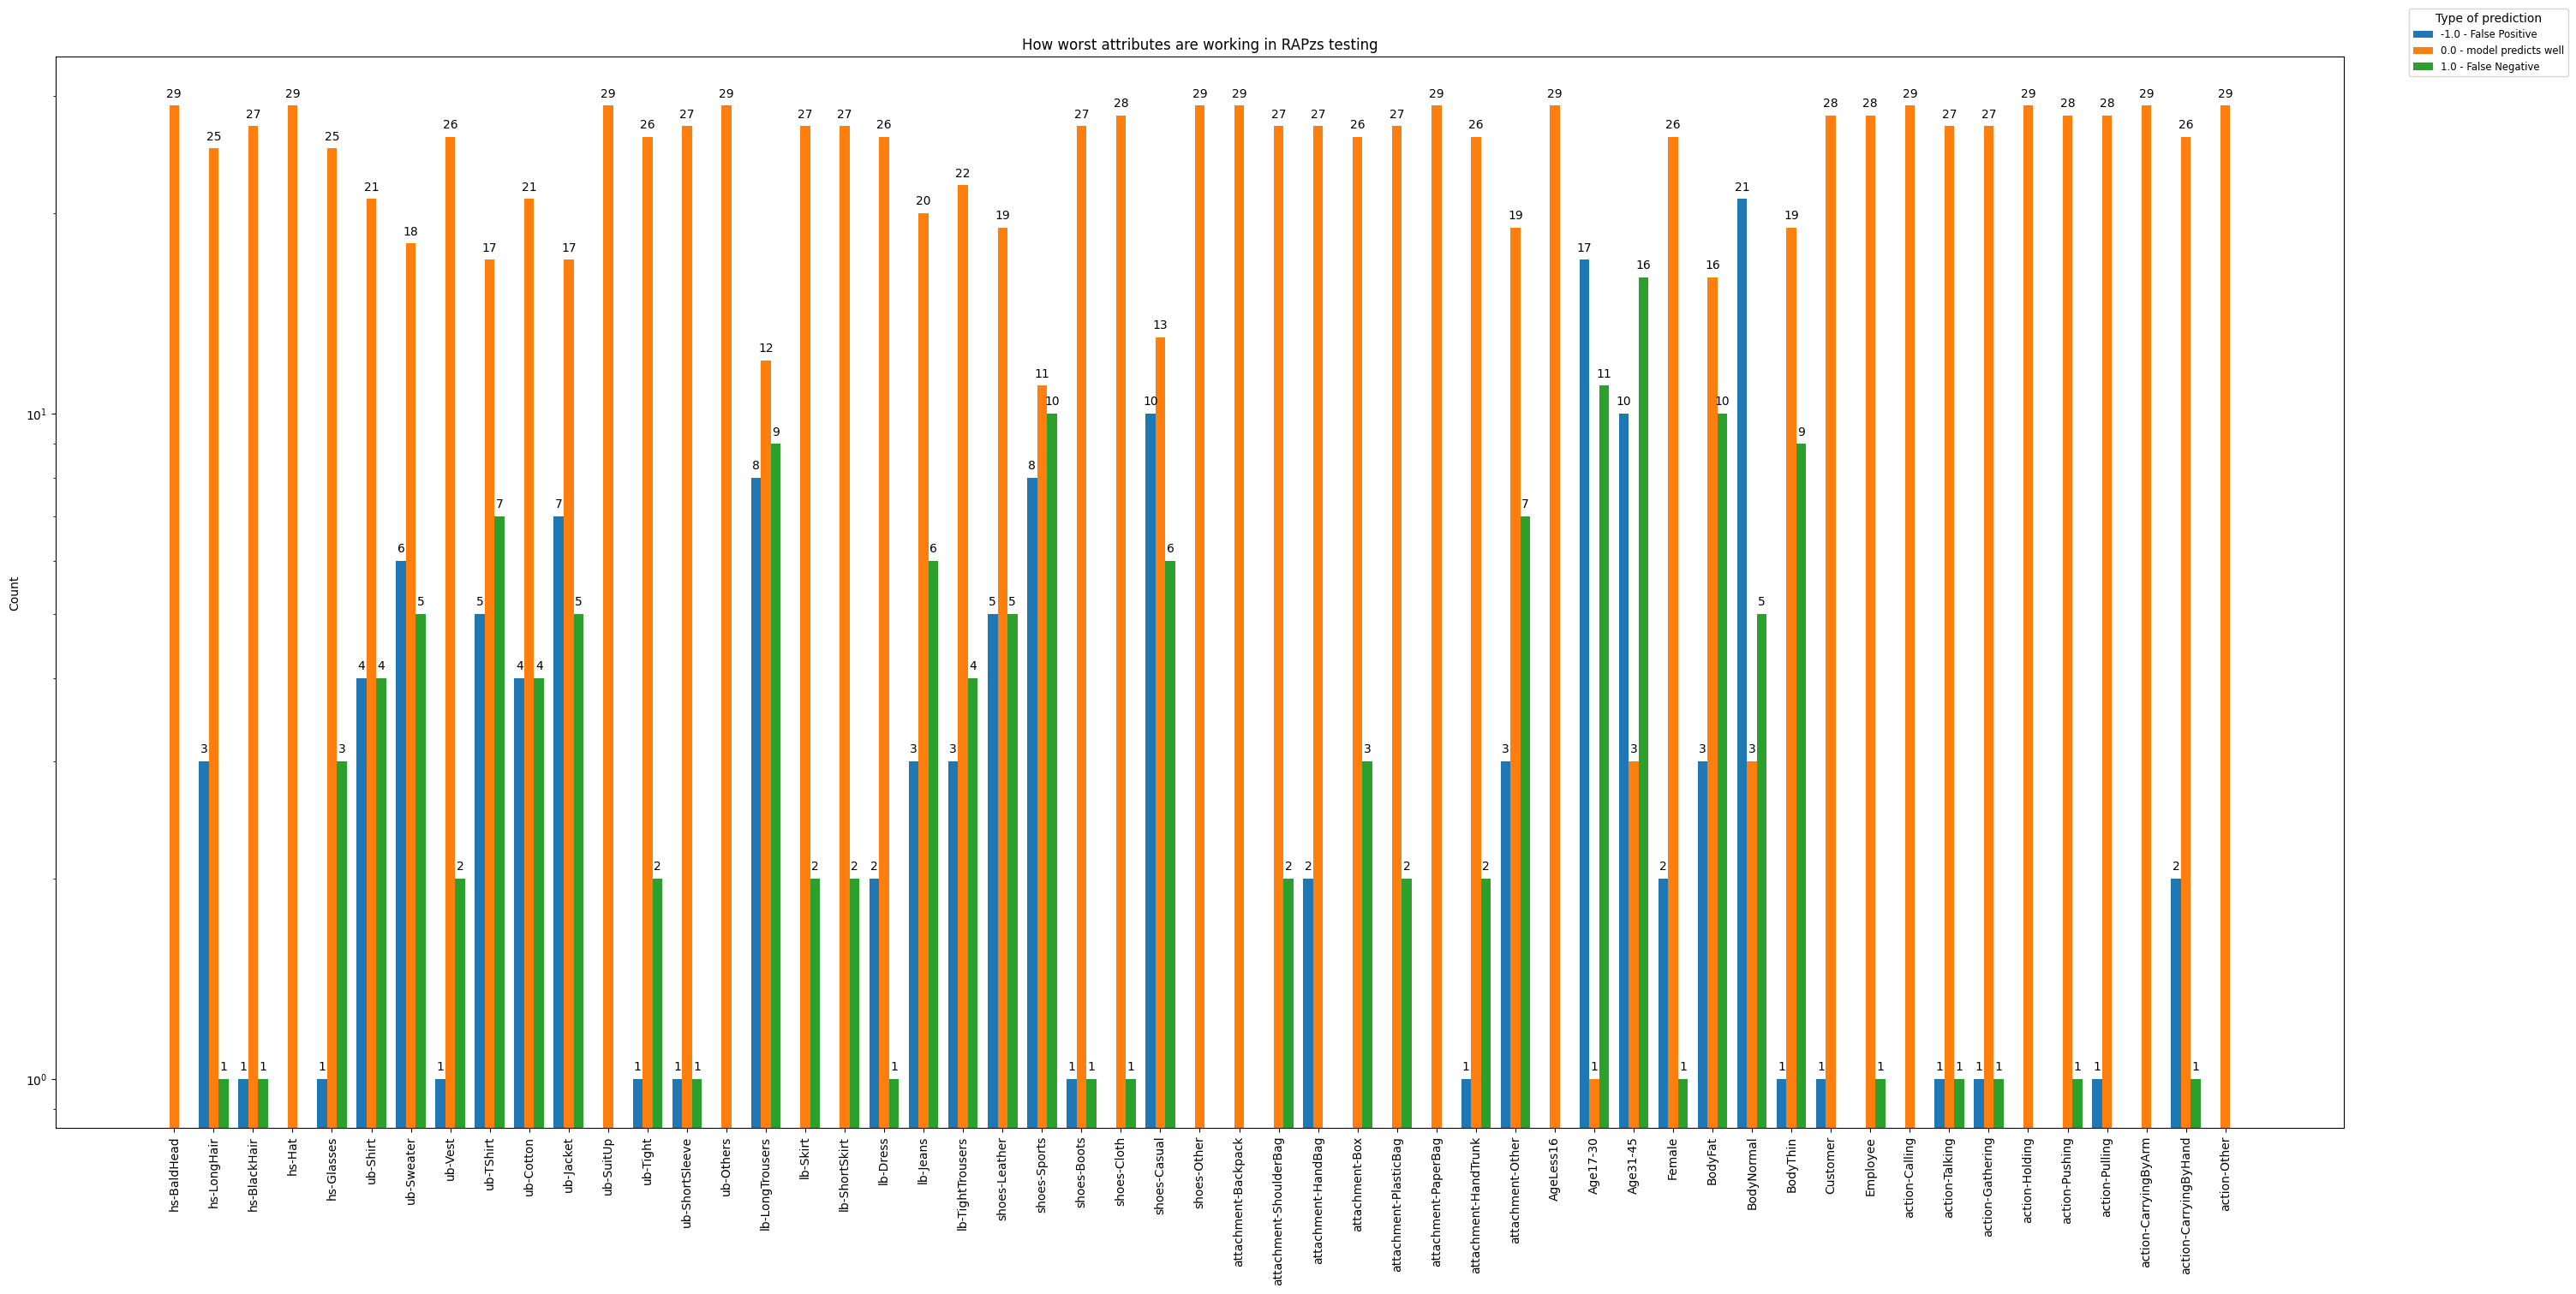

In [7]:
columns = listAttributesRAPzs
valuesAppear = valuesAppearTestingWorst
tittleGraph = 'How worst attributes are working in RAPzs testing'
tittleLegend = 'Type of prediction'
plotHowAttributesAreWorking(columns,valuesAppear, tittleGraph, tittleLegend)

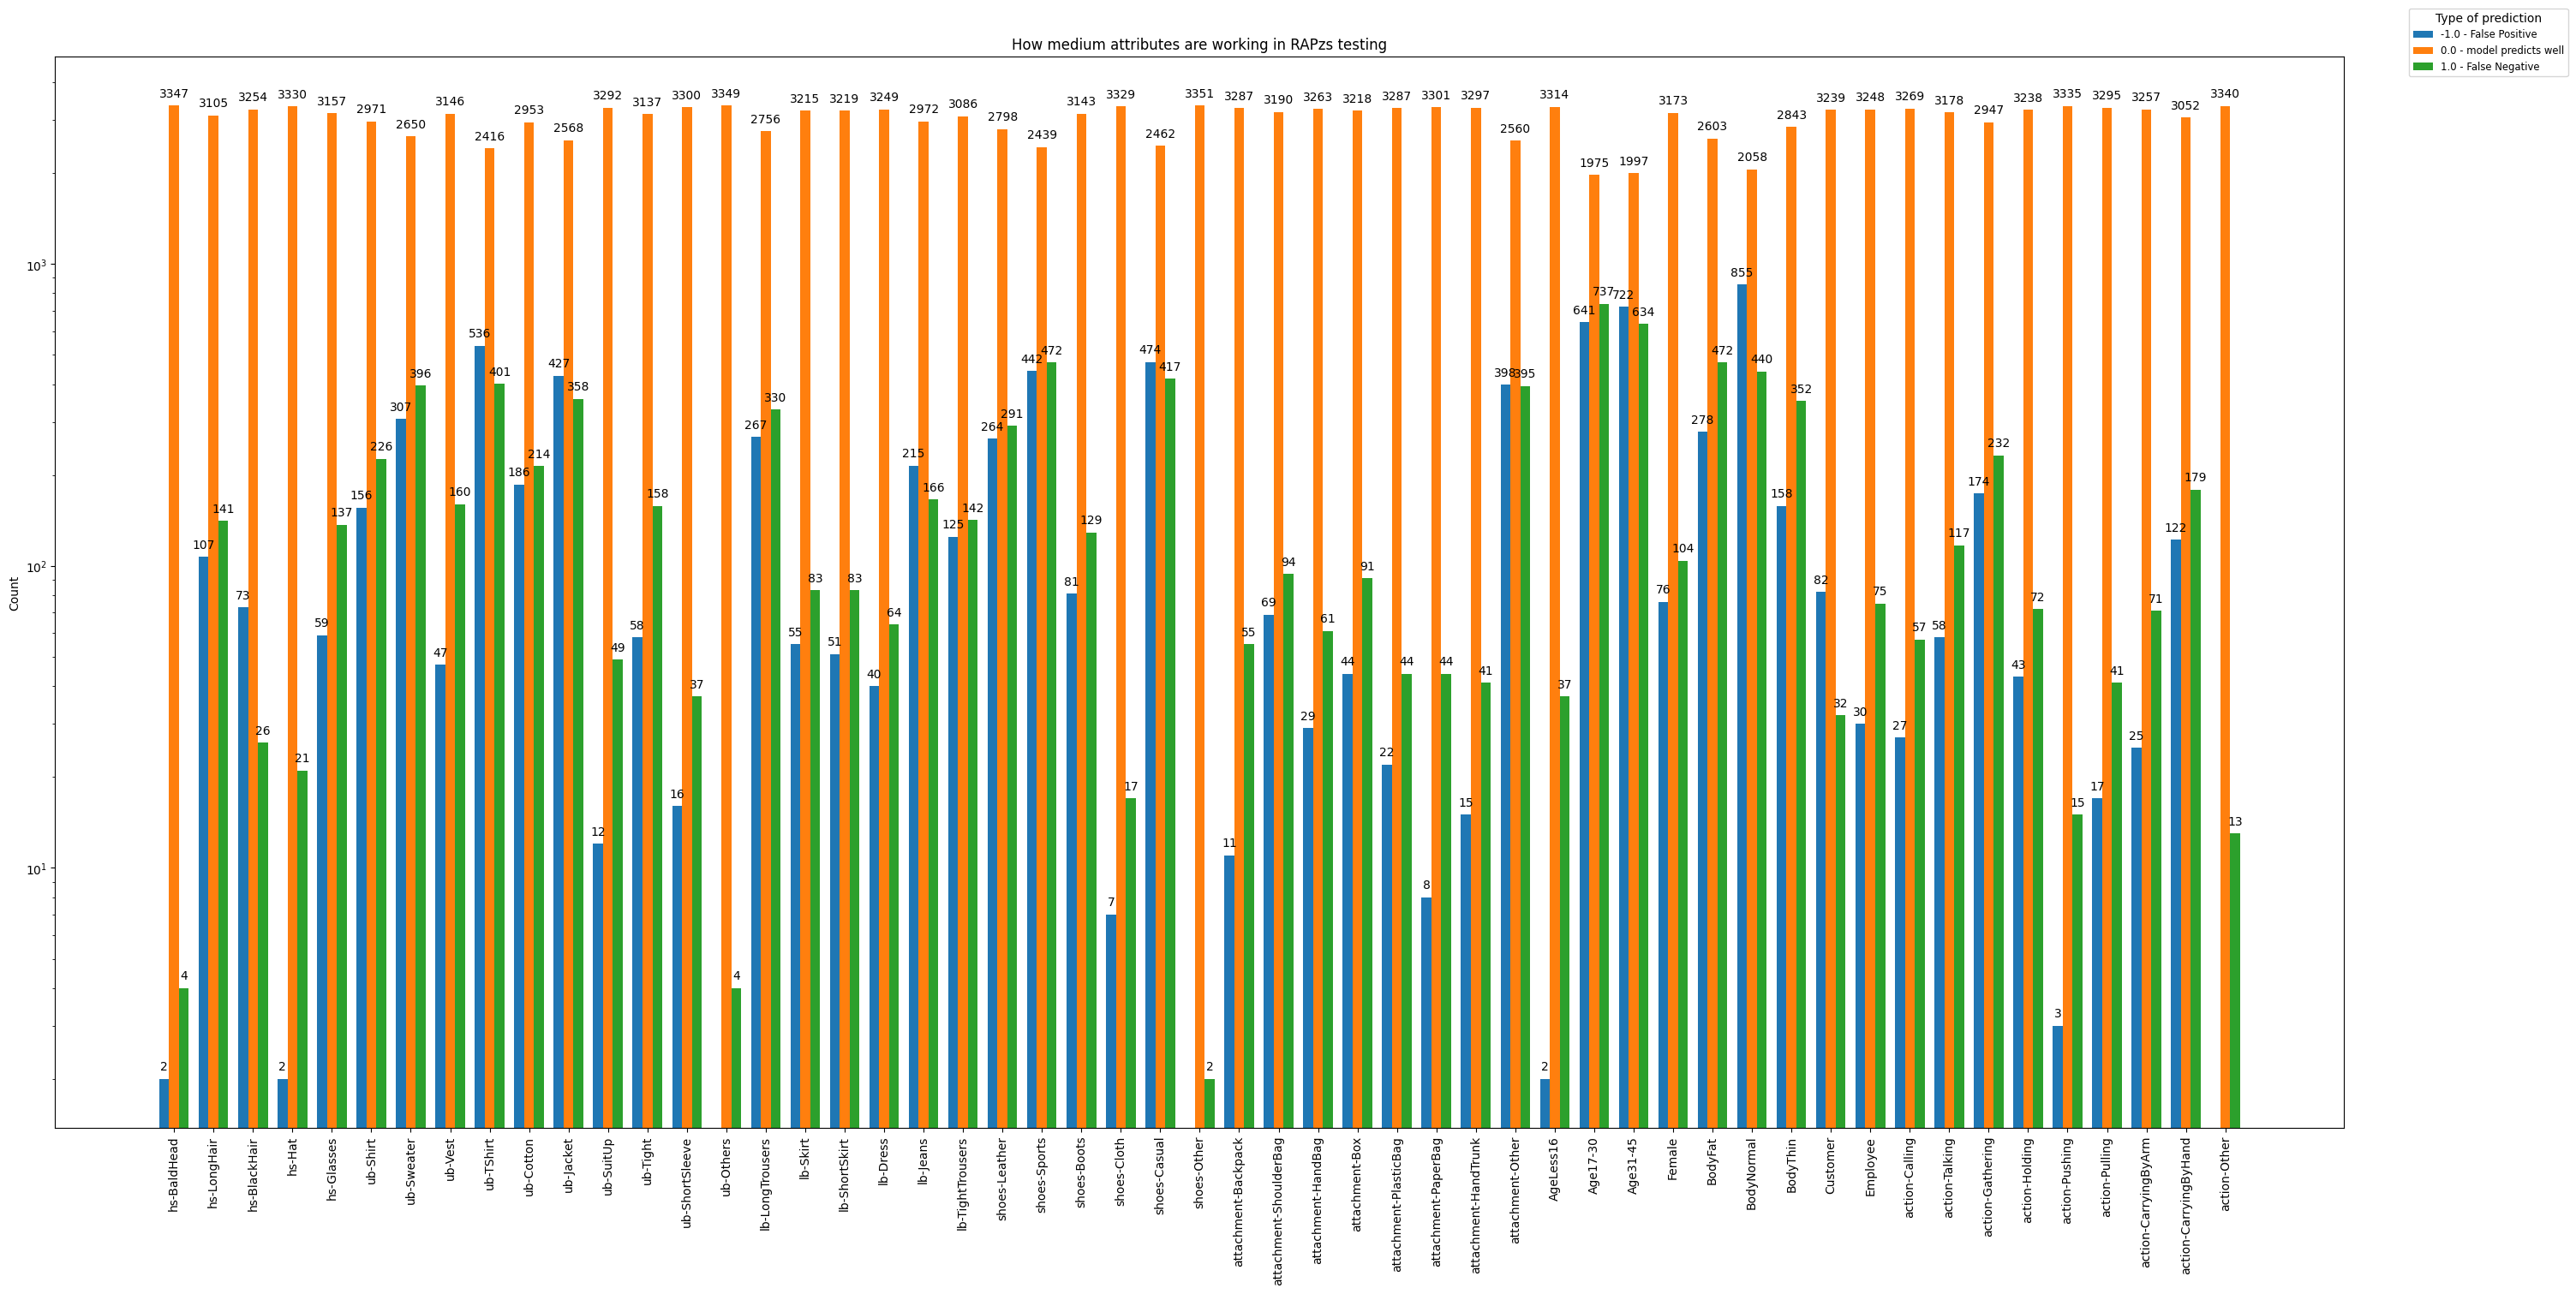

In [18]:
dfTestingMedium = pd.DataFrame(columns=columnsDF)
for name, index in zip(listNameImgMediumTesting, listNameIndexMediumTesting):
    value = listNameValueMediumTesting[listNameImgMediumTesting.index(name)]

    xnorRow = [value, name]
    diffGTPredicted = [(gt - predicted) for gt, predicted in zip(valuesGTTesting[index], valuesPredictedTesting[index])]
    
    # this row is the difference between the gt and the predicted
    xnorRow.extend(diffGTPredicted)
    #xnorRow.extend(fillList)

    dfTestingMedium.loc[-1] = xnorRow
    dfTestingMedium.index = dfTestingMedium.index + 1
    dfTestingMedium = dfTestingMedium.sort_index()


dfAppearsTestingMedium = dfTestingMedium[listAttributesRAPzs].apply(pd.value_counts).fillna(0)
valuesAppearTestingMedium = {}
for i, row in dfAppearsTestingMedium.iterrows():
    valuesAppearTestingMedium[i] = row.values.tolist()

columns = listAttributesRAPzs
valuesAppear = valuesAppearTestingMedium
tittleGraph = 'How medium attributes are working in RAPzs testing'
tittleLegend = 'Type of prediction'
plotHowAttributesAreWorking(columns,valuesAppear, tittleGraph, tittleLegend)

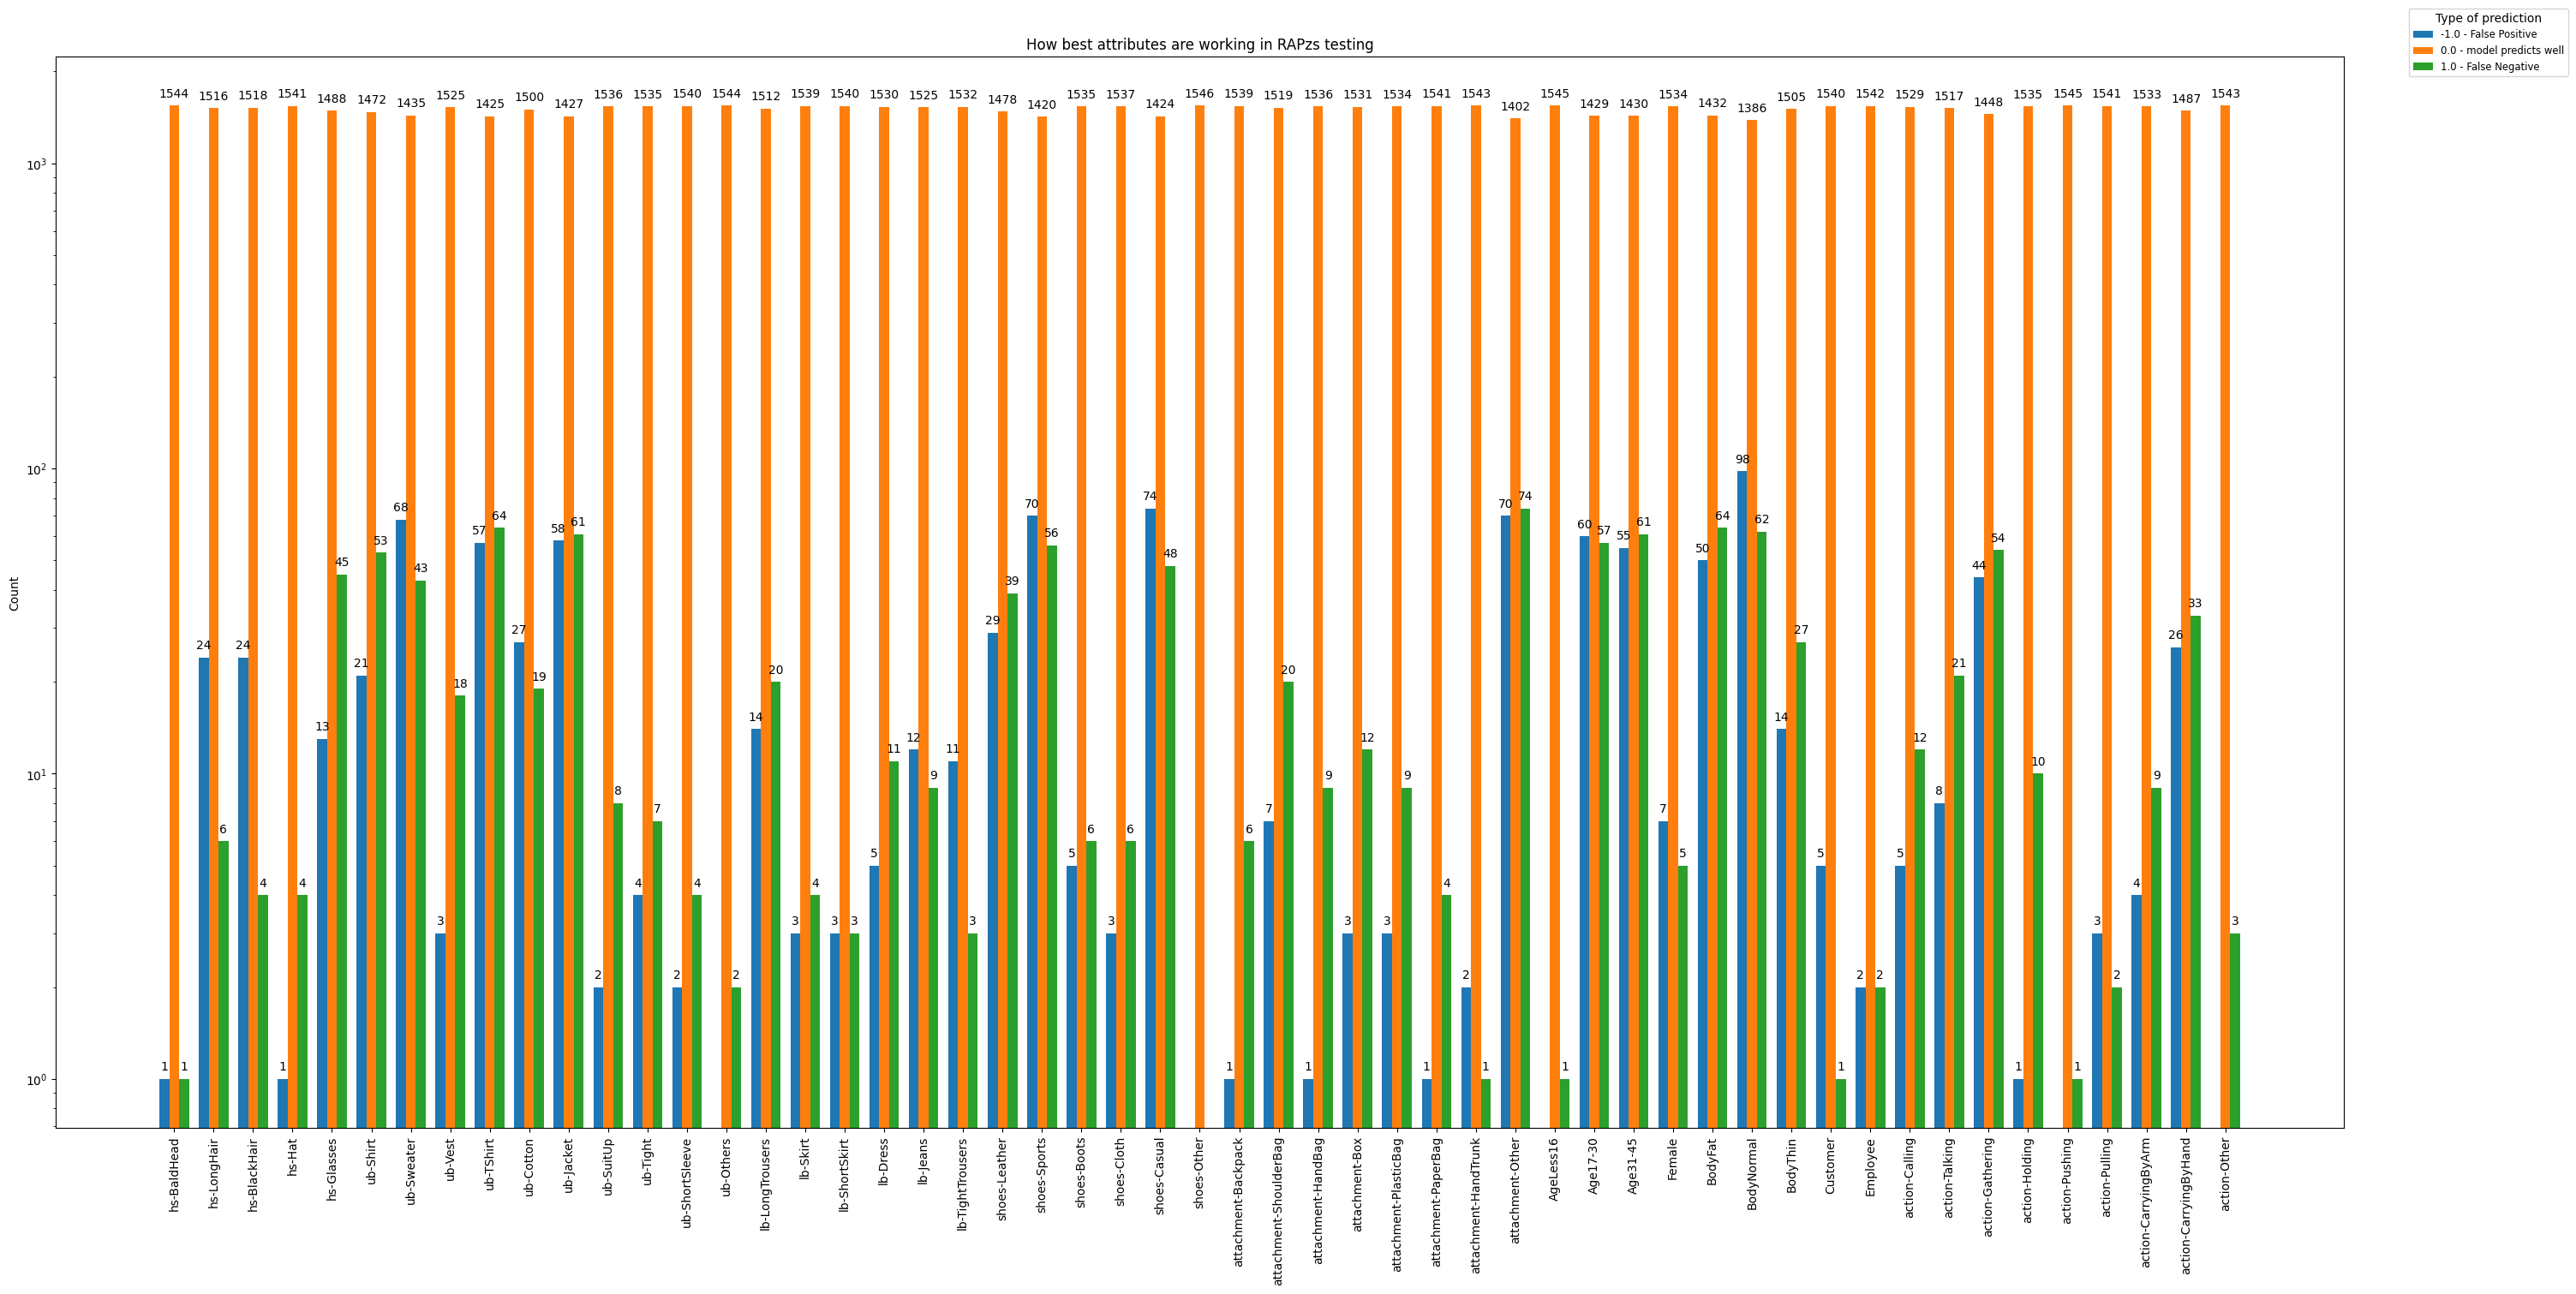

In [19]:
dfTestingBest = pd.DataFrame(columns=columnsDF)
for name, index in zip(listNameImgBestTesting, listNameIndexBestTesting):
    value = listNameValueBestTesting[listNameImgBestTesting.index(name)]

    xnorRow = [value, name]

    diffGTPredicted = [(gt - predicted) for gt, predicted in zip(valuesGTTesting[index], valuesPredictedTesting[index])]
    
    # this row is the difference between the gt and the predicted
    xnorRow.extend(diffGTPredicted)
    #xnorRow.extend(fillList)

    dfTestingBest.loc[-1] = xnorRow
    dfTestingBest.index = dfTestingBest.index + 1
    dfTestingBest = dfTestingBest.sort_index()


dfAppearsTestingBest = dfTestingBest[listAttributesRAPzs].apply(pd.value_counts).fillna(0)
valuesAppearTestingBest = {}
for i, row in dfAppearsTestingBest.iterrows():
    valuesAppearTestingBest[i] = row.values.tolist()

columns = listAttributesRAPzs
valuesAppear = valuesAppearTestingBest
tittleGraph = 'How best attributes are working in RAPzs testing'
tittleLegend = 'Type of prediction'
plotHowAttributesAreWorking(columns,valuesAppear, tittleGraph, tittleLegend)

## Training

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


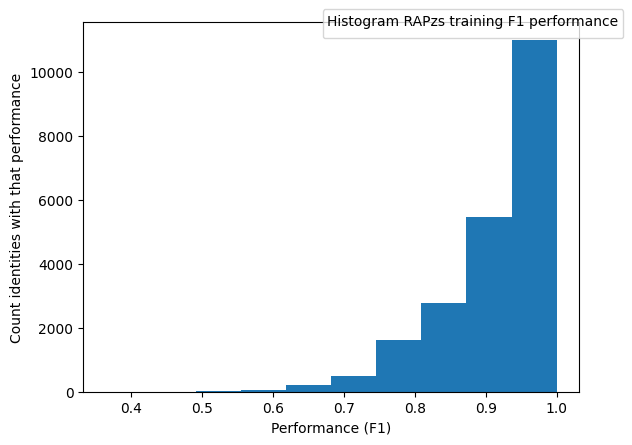

<Figure size 640x480 with 0 Axes>

In [96]:
pathToTrainingMetricF1 = 'RAPzs/training_dict_instance_f1.json'
pathToTrainingDataGTPredicted = 'RAPzs/training_dict_gt_predicted.json'
fileTrainingGTPredicted = open(pathToTrainingDataGTPredicted)
jsonTrainingGTPredicted = json.load(fileTrainingGTPredicted)


fileTrainingMetricF1 = open(pathToTrainingMetricF1)
jsonTrainingMetricF1 = json.load(fileTrainingMetricF1)

values = jsonTrainingMetricF1['training f1']

listNames = []
for list in jsonTrainingMetricF1['img name training']:
    for item in list:
        listNames.append(item)

dfTrainingRAPzs = pd.DataFrame()
dfTrainingRAPzs['values'] = values
dfTrainingRAPzs['name'] = listNames

plt.hist(dfTrainingRAPzs['values'])
plt.xlabel('Performance (F1)')
plt.ylabel('Count identities with that performance')
tittle='Histogram RAPzs training F1 performance'
plt.legend(bbox_to_anchor=(1.1, 1.05), title=tittle, fontsize='small', fancybox=True)
plt.show()
plt.savefig(pathToSaveComplexIdentities+'plotHistogramTrainingIdentities.pdf')

In [21]:
maxIdentities = -1
pd.options.display.max_colwidth = 100
medium = 0.4
best = 0.85
listNameValueWorstTraining = dfTrainingRAPzs[dfTrainingRAPzs['values']<medium][0:]['values'].tolist()
listNameImgWorstTraining = dfTrainingRAPzs[dfTrainingRAPzs['values']<medium][0:]['name'].tolist()
listNameIndexWorstTraining = dfTrainingRAPzs[dfTrainingRAPzs['values']<medium][0:].index.tolist()

listNameValueMediumTraining = dfTrainingRAPzs[(dfTrainingRAPzs['values']<best) & (dfTrainingRAPzs['values']>=medium)][0:]['values'].tolist()
listNameImgMediumTraining = dfTrainingRAPzs[(dfTrainingRAPzs['values']<best) & (dfTrainingRAPzs['values']>=medium)][0:]['name'].tolist()
listNameIndexMediumTraining = dfTrainingRAPzs[(dfTrainingRAPzs['values']<best) & (dfTrainingRAPzs['values']>=medium)][0:].index.tolist()

listNameValueBestTraining = dfTrainingRAPzs[dfTrainingRAPzs['values']>best][0:]['values'].tolist()
listNameImgBestTraining = dfTrainingRAPzs[dfTrainingRAPzs['values']>best][0:]['name'].tolist()
listNameIndexBestTraining = dfTrainingRAPzs[dfTrainingRAPzs['values']>best][0:].index.tolist()

valuesGTTraining = jsonTrainingGTPredicted['training gt']
valuesPredictedTrainingOld = jsonTrainingGTPredicted['training predicted']
valuesPredictedTraining = []
for vector in valuesPredictedTrainingOld:
    newVector = []
    for value in vector:
        newVector.append(value)
    valuesPredictedTraining.append(newVector)

In [22]:
dfTrainingWorst = pd.DataFrame(columns=columnsDF)
for name, index in zip(listNameImgWorstTraining, listNameIndexWorstTraining):
    value = listNameValueWorstTraining[listNameImgWorstTraining.index(name)]
    xnorRow = [value, name]

    diffGTPredicted = [(gt - predicted) for gt, predicted in zip(valuesGTTraining[index], valuesPredictedTraining[index])]
    
    # this row is the difference between the gt and the predicted
    xnorRow.extend(diffGTPredicted)
    #xnorRow.extend(fillList)

    dfTrainingWorst.loc[-1] = xnorRow
    dfTrainingWorst.index = dfTrainingWorst.index + 1
    dfTrainingWorst = dfTrainingWorst.sort_index()


dfAppearsTrainingWorst = dfTrainingWorst[listAttributesRAPzs].apply(pd.value_counts).fillna(0)
valuesAppearTrainingWorst = {}
for i, row in dfAppearsTrainingWorst.iterrows():
    valuesAppearTrainingWorst[i] = row.values.tolist()


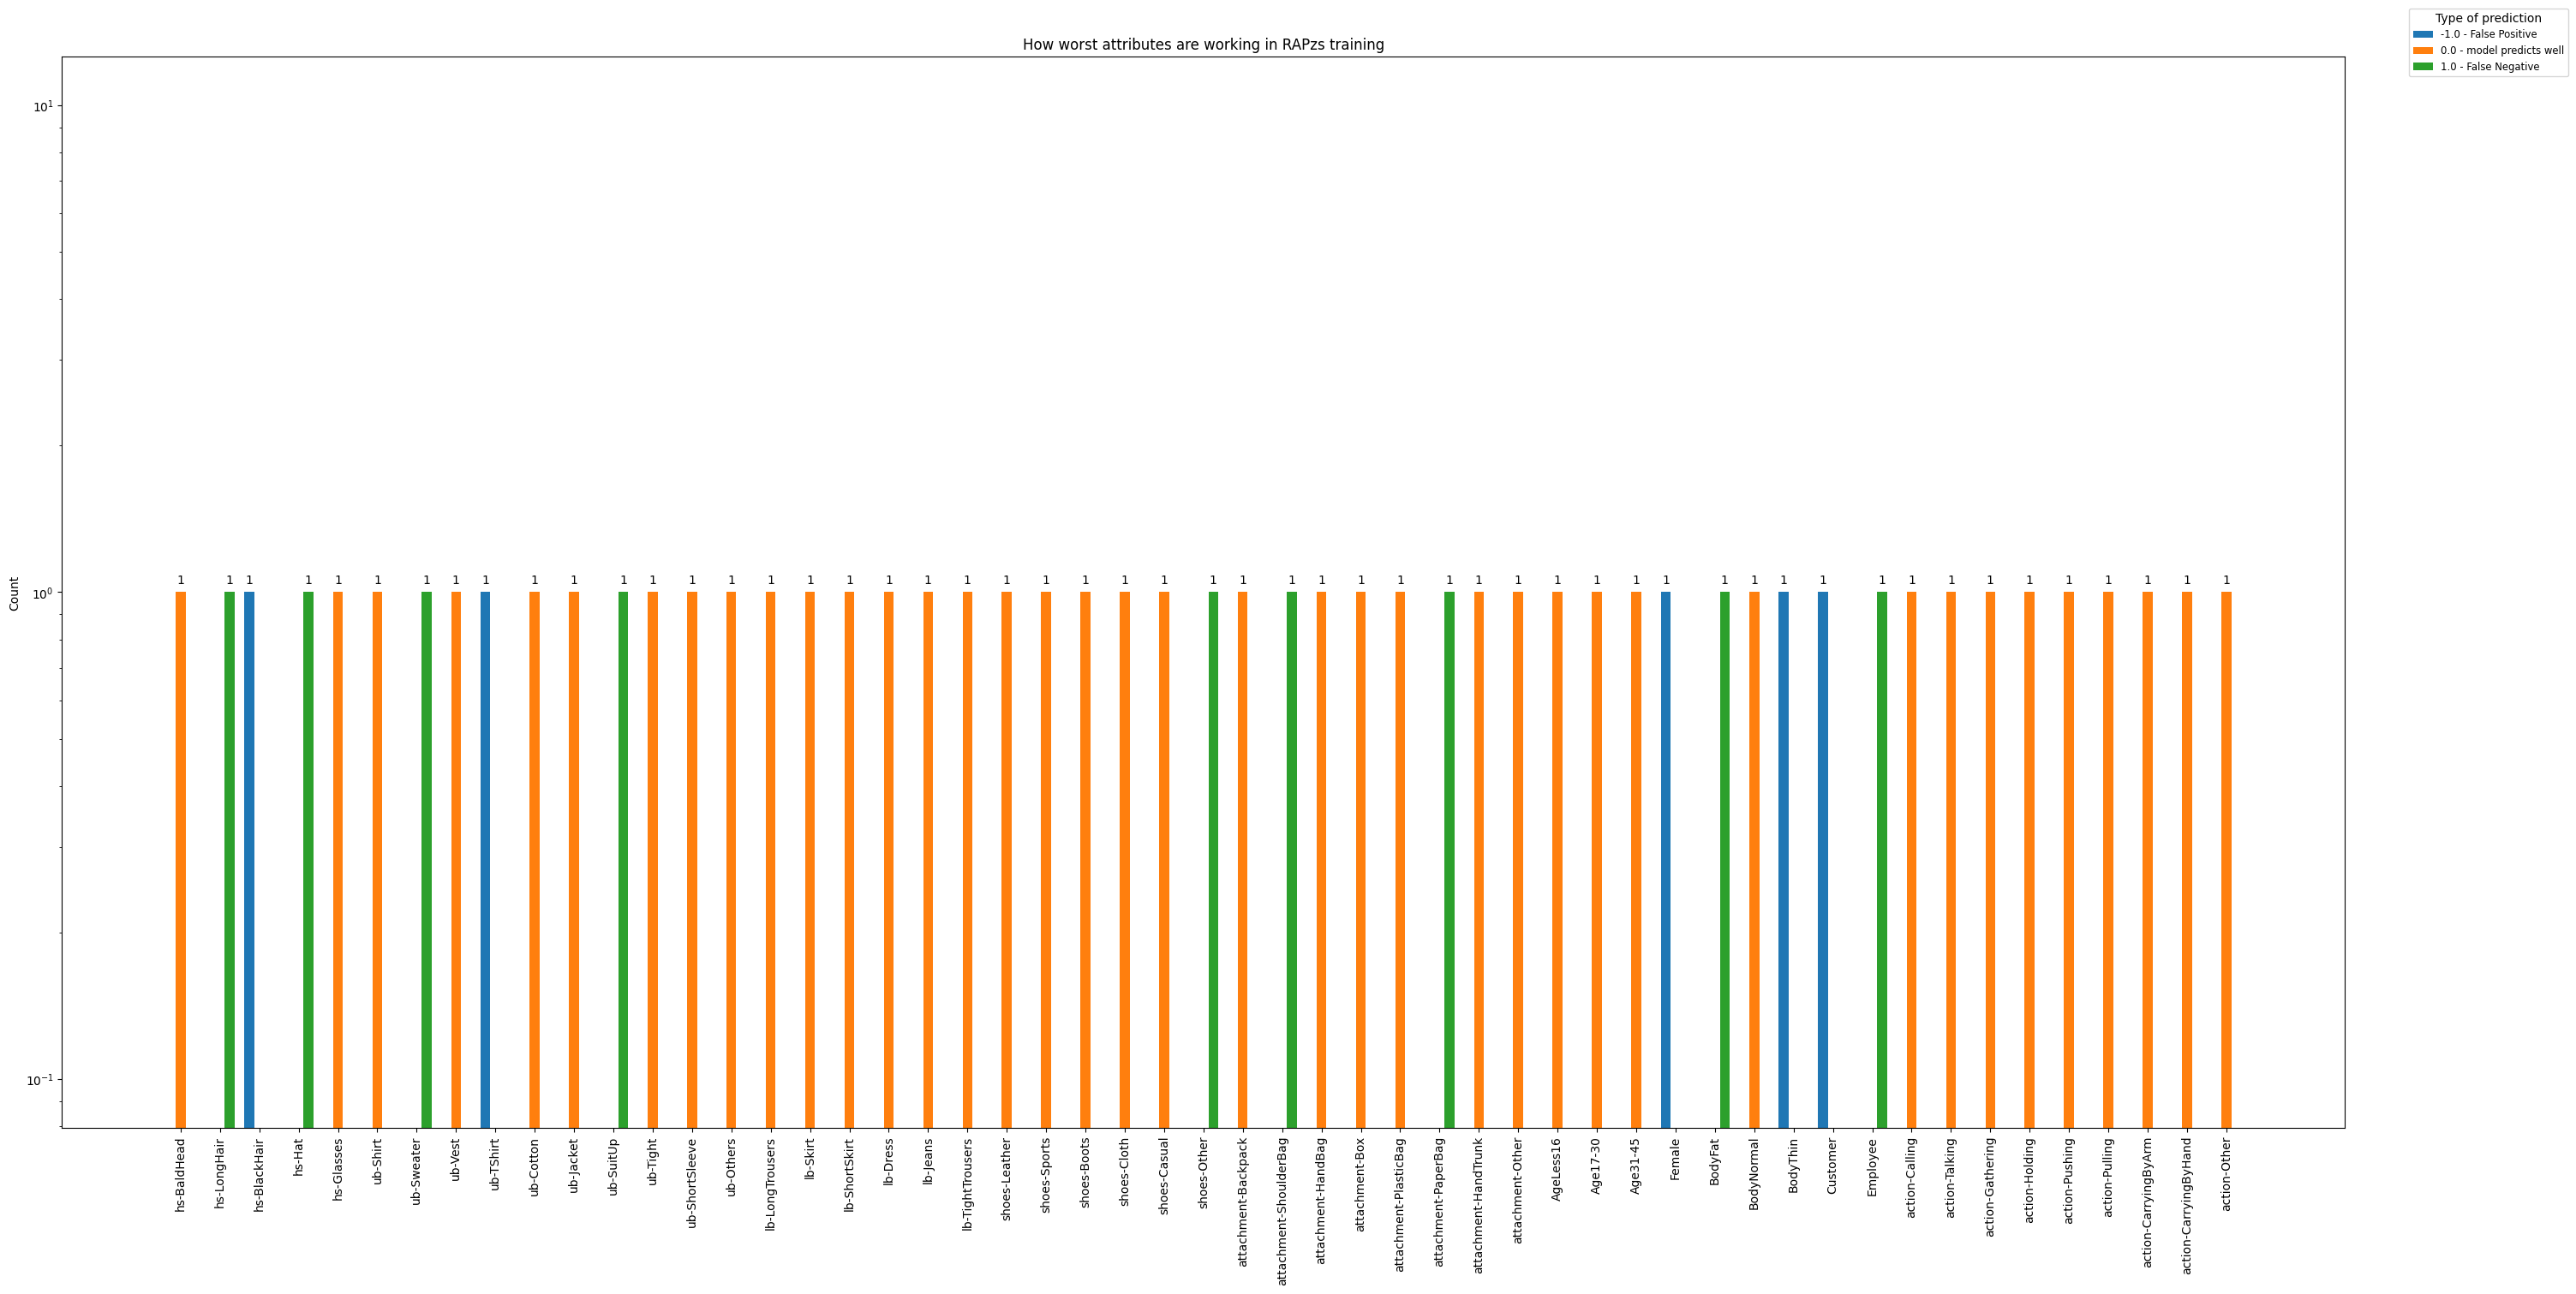

In [23]:
columns = listAttributesRAPzs
valuesAppear = valuesAppearTrainingWorst
tittleGraph = 'How worst attributes are working in RAPzs training'
tittleLegend = 'Type of prediction'
plotHowAttributesAreWorking(columns,valuesAppear, tittleGraph, tittleLegend)

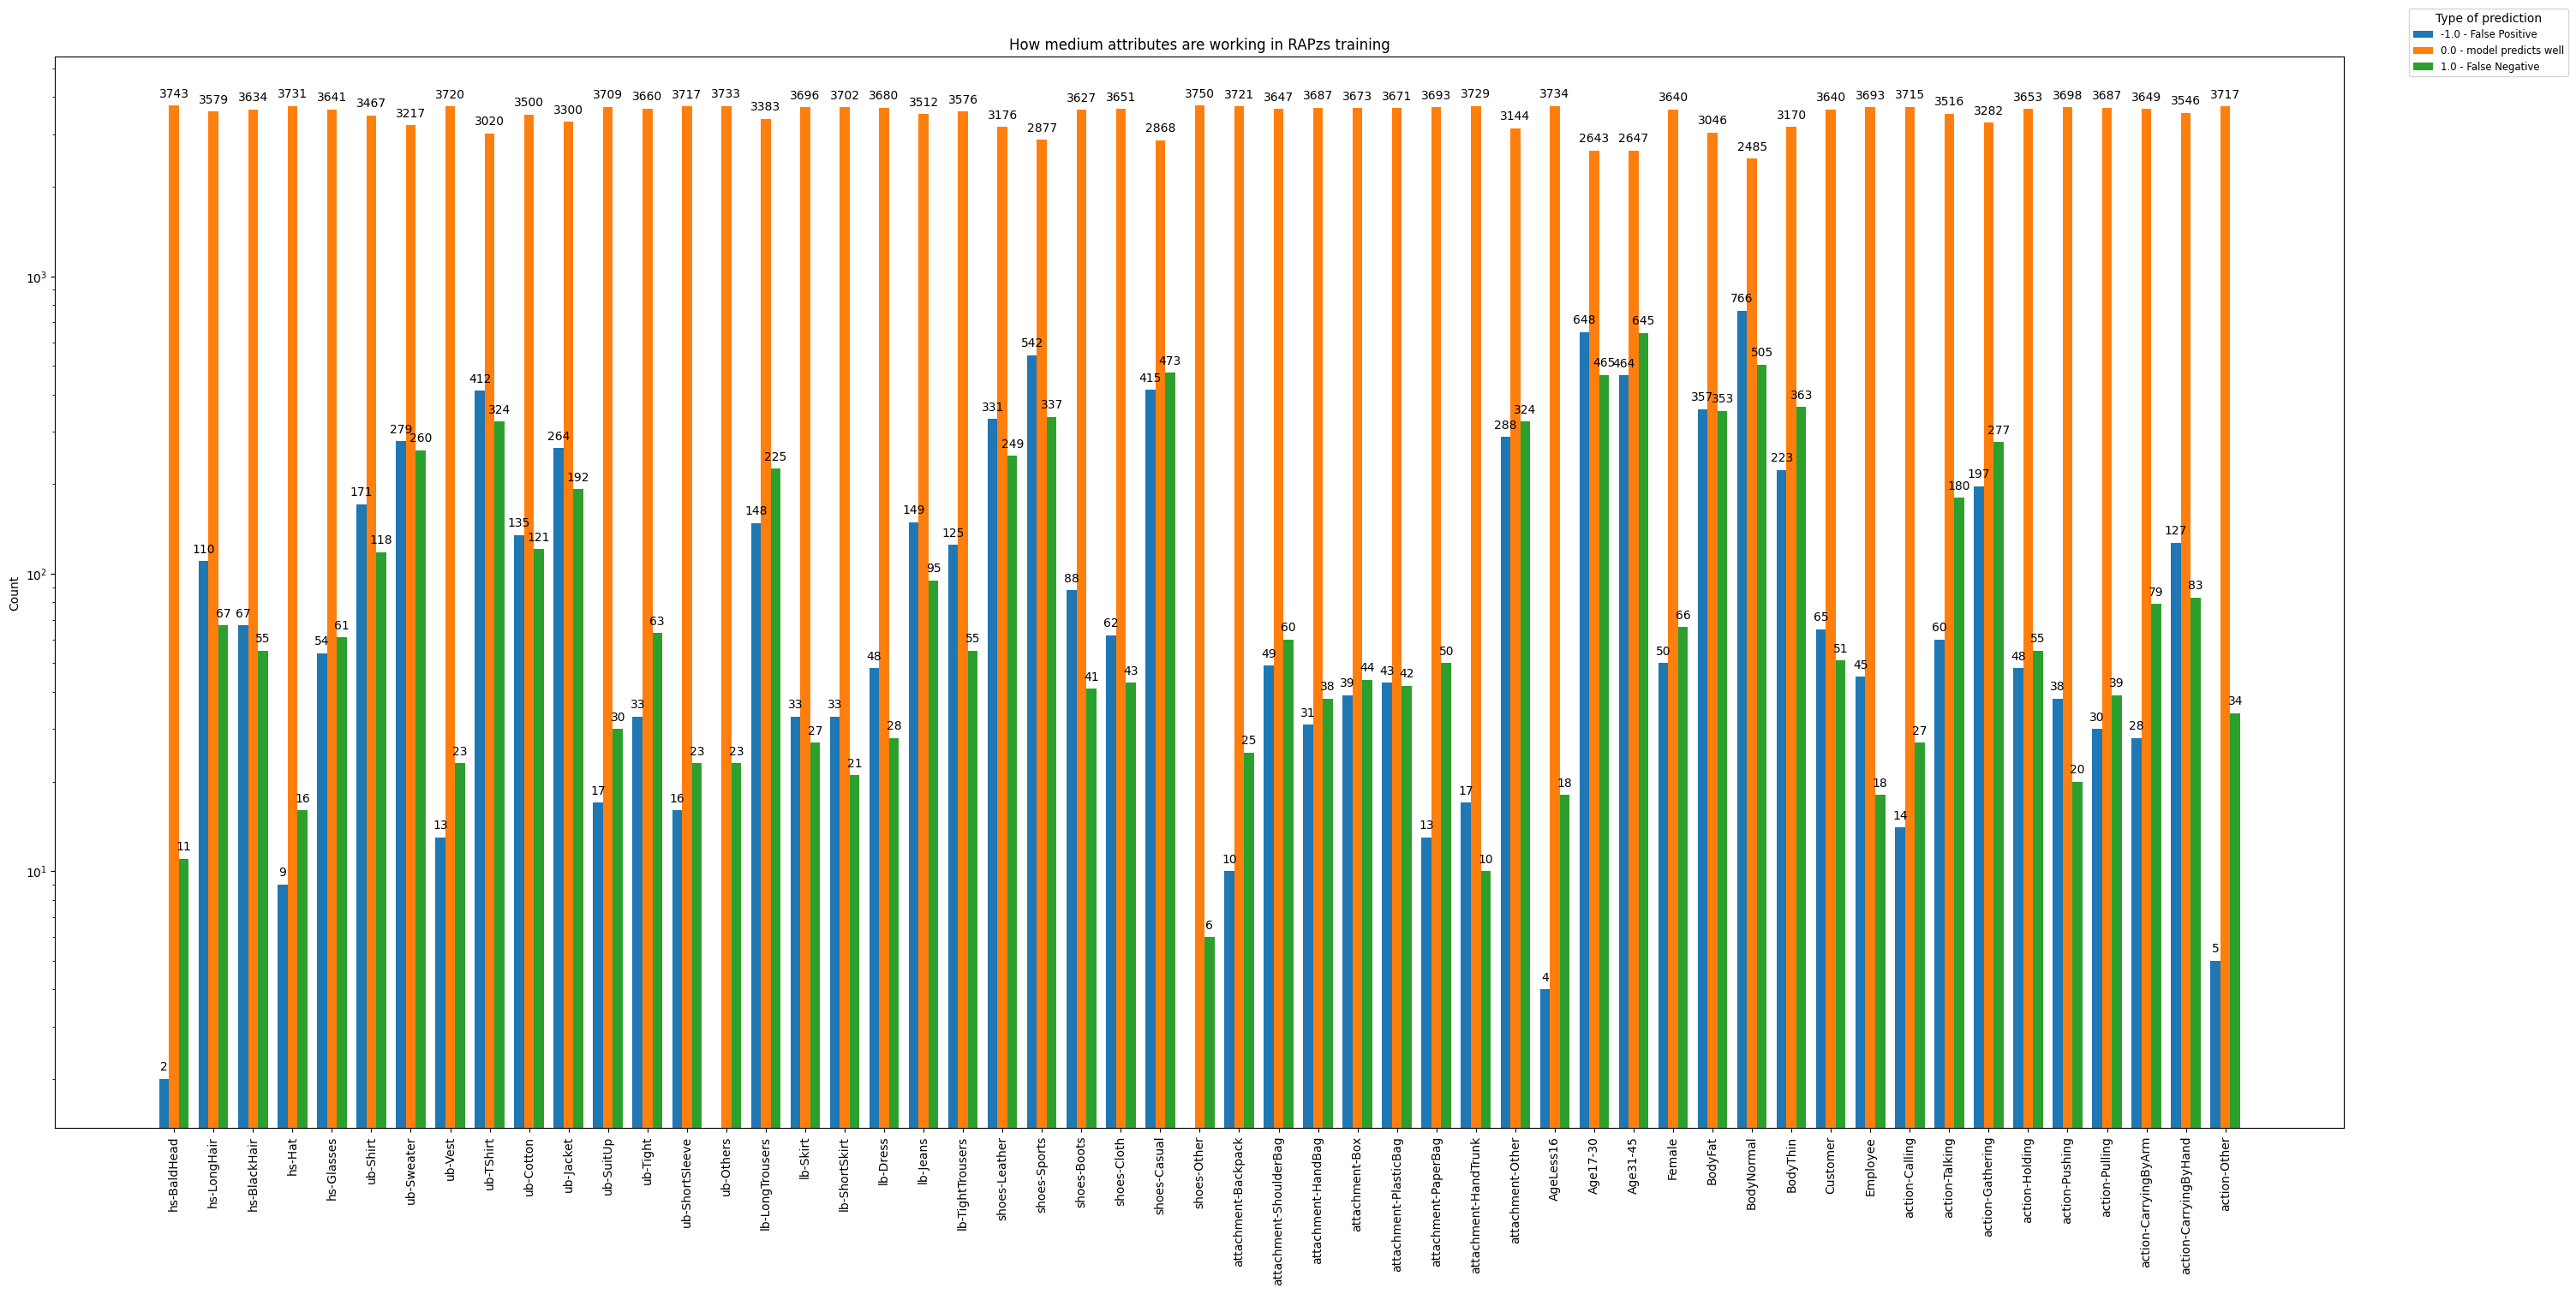

In [24]:
dfTrainingMedium = pd.DataFrame(columns=columnsDF)
for name, index in zip(listNameImgMediumTraining, listNameIndexMediumTraining):
    value = listNameValueMediumTraining[listNameImgMediumTraining.index(name)]

    xnorRow = [value, name]
    diffGTPredicted = [(gt - predicted) for gt, predicted in zip(valuesGTTraining[index], valuesPredictedTraining[index])]
    
    # this row is the difference between the gt and the predicted
    xnorRow.extend(diffGTPredicted)
    #xnorRow.extend(fillList)

    dfTrainingMedium.loc[-1] = xnorRow
    dfTrainingMedium.index = dfTrainingMedium.index + 1
    dfTrainingMedium = dfTrainingMedium.sort_index()


dfAppearsTrainingMedium = dfTrainingMedium[listAttributesRAPzs].apply(pd.value_counts).fillna(0)
valuesAppearTrainingMedium = {}
for i, row in dfAppearsTrainingMedium.iterrows():
    valuesAppearTrainingMedium[i] = row.values.tolist()

columns = listAttributesRAPzs
valuesAppear = valuesAppearTrainingMedium
tittleGraph = 'How medium attributes are working in RAPzs training'
tittleLegend = 'Type of prediction'
plotHowAttributesAreWorking(columns,valuesAppear, tittleGraph, tittleLegend)

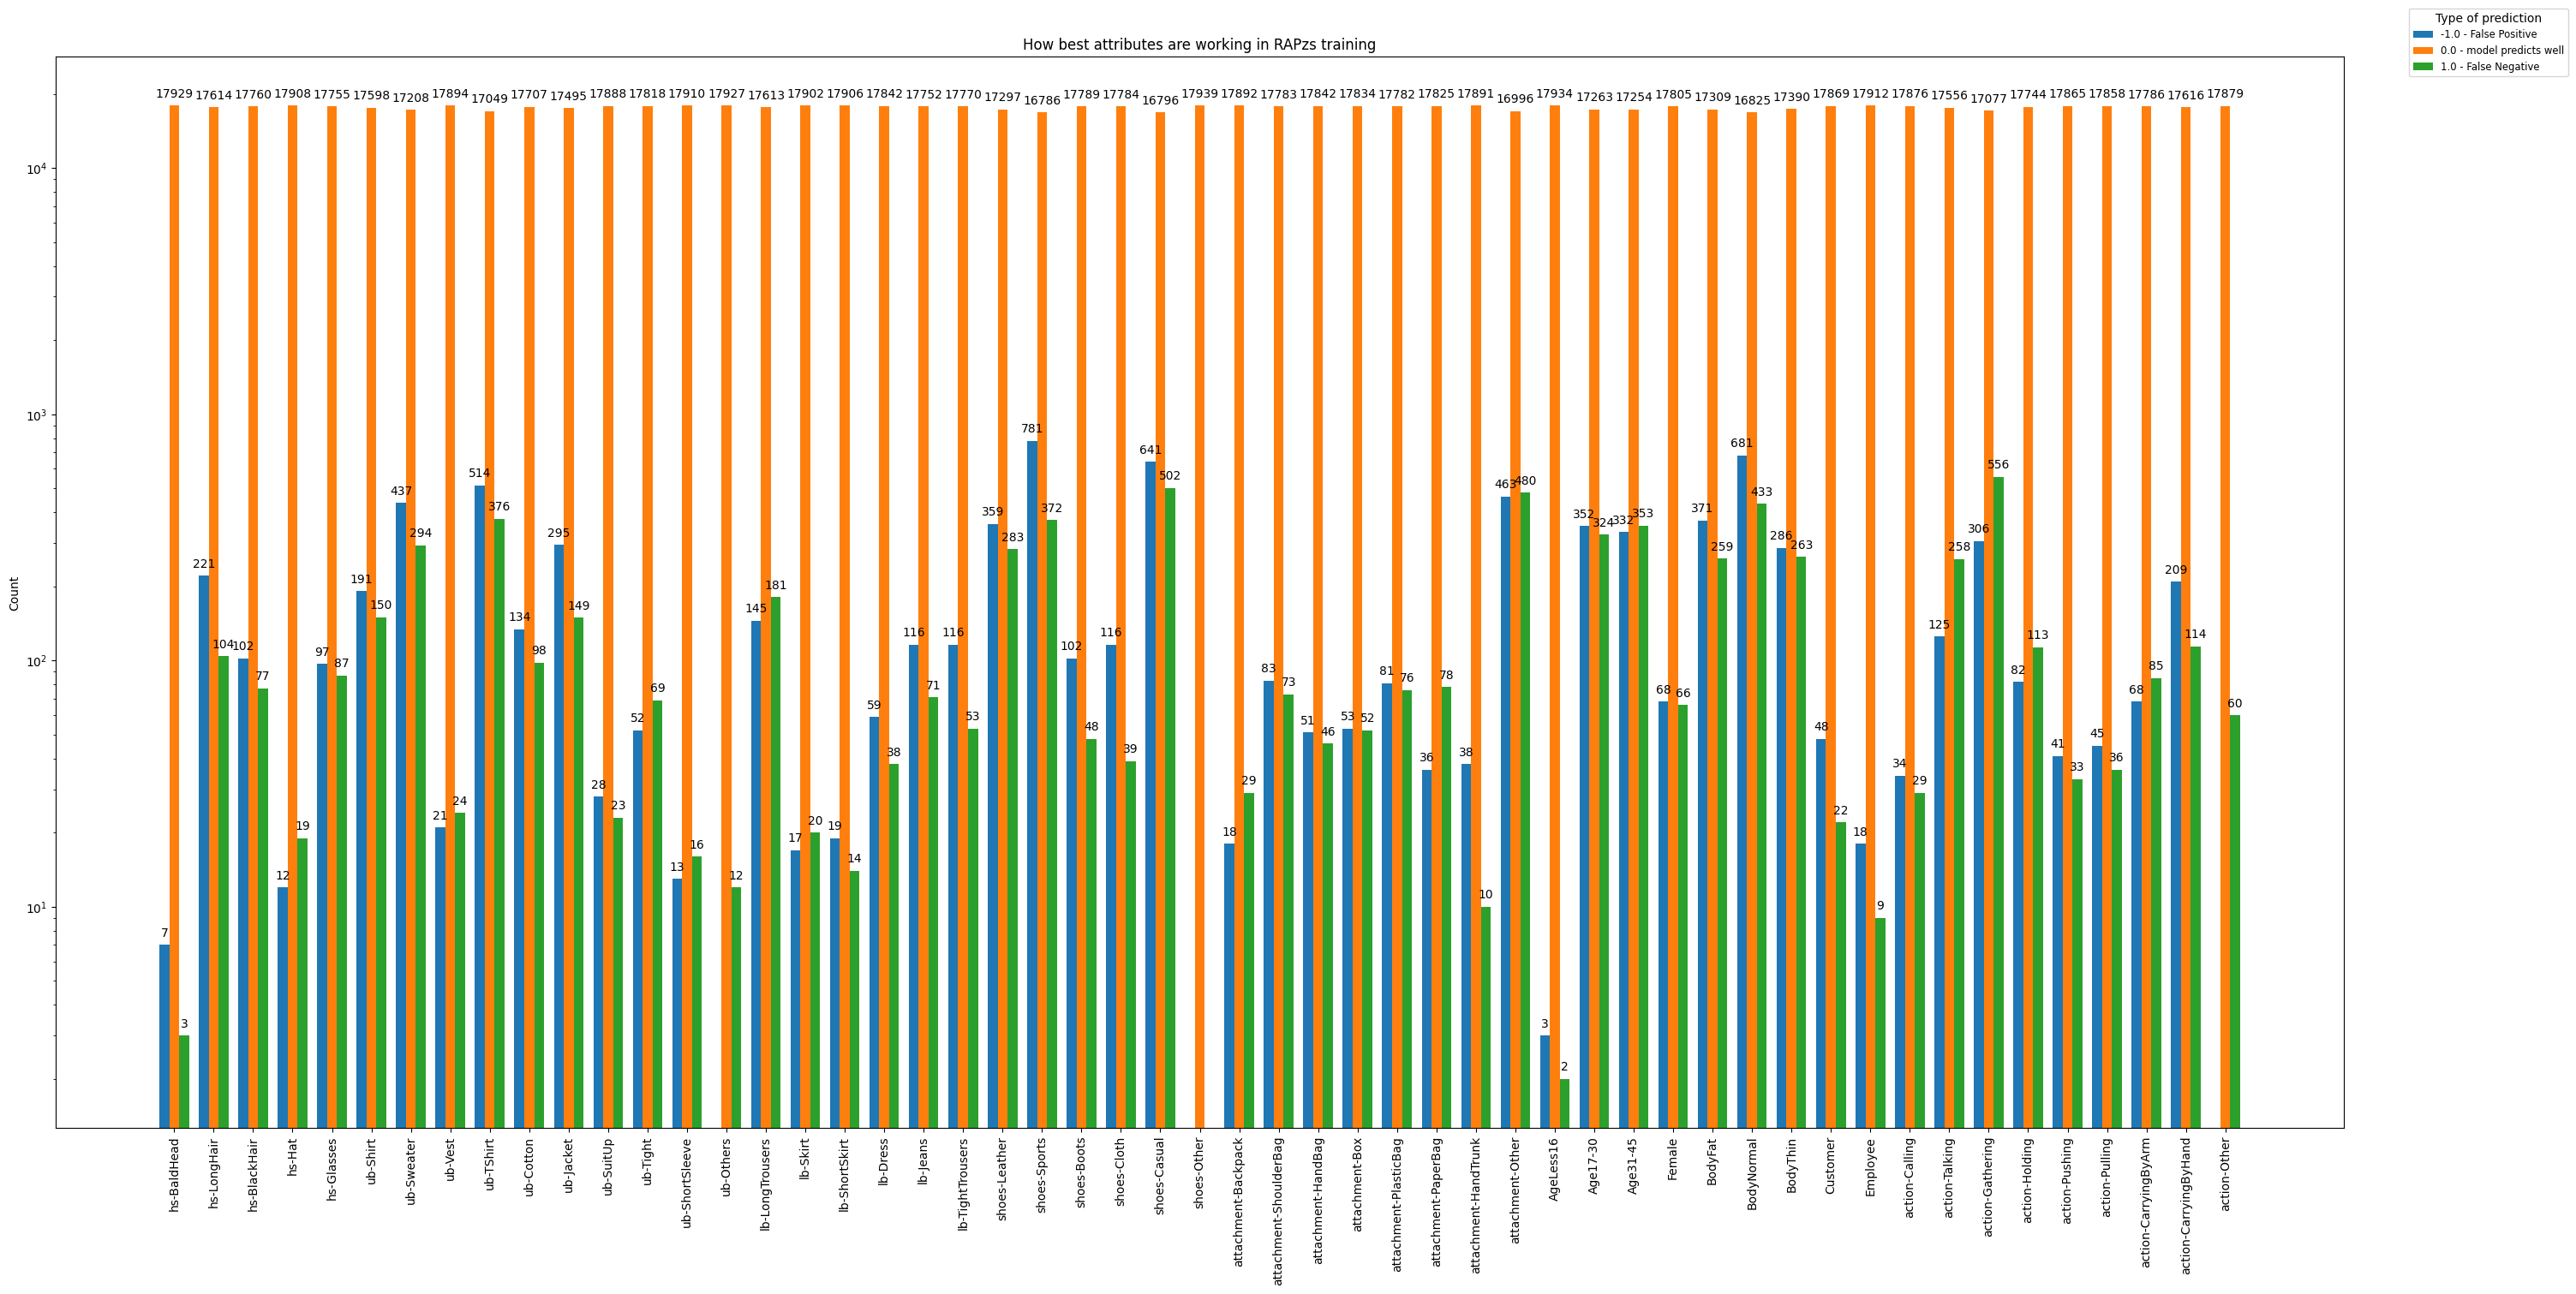

In [25]:
dfTrainingBest = pd.DataFrame(columns=columnsDF)
for name, index in zip(listNameImgBestTraining, listNameIndexBestTraining):
    value = listNameValueBestTraining[listNameImgBestTraining.index(name)]

    xnorRow = [value, name]

    diffGTPredicted = [(gt - predicted) for gt, predicted in zip(valuesGTTraining[index], valuesPredictedTraining[index])]
    
    # this row is the difference between the gt and the predicted
    xnorRow.extend(diffGTPredicted)
    #xnorRow.extend(fillList)

    dfTrainingBest.loc[-1] = xnorRow
    dfTrainingBest.index = dfTrainingBest.index + 1
    dfTrainingBest = dfTrainingBest.sort_index()


dfAppearsTrainingBest = dfTrainingBest[listAttributesRAPzs].apply(pd.value_counts).fillna(0)
valuesAppearTrainingBest = {}
for i, row in dfAppearsTrainingBest.iterrows():
    valuesAppearTrainingBest[i] = row.values.tolist()

columns = listAttributesRAPzs
valuesAppear = valuesAppearTrainingBest
tittleGraph = 'How best attributes are working in RAPzs training'
tittleLegend = 'Type of prediction'
plotHowAttributesAreWorking(columns,valuesAppear, tittleGraph, tittleLegend)

In [26]:
x = np.arange(0, len(columns)*4.8, 4.8) 
x

array([  0. ,   4.8,   9.6,  14.4,  19.2,  24. ,  28.8,  33.6,  38.4,
        43.2,  48. ,  52.8,  57.6,  62.4,  67.2,  72. ,  76.8,  81.6,
        86.4,  91.2,  96. , 100.8, 105.6, 110.4, 115.2, 120. , 124.8,
       129.6, 134.4, 139.2, 144. , 148.8, 153.6, 158.4, 163.2, 168. ,
       172.8, 177.6, 182.4, 187.2, 192. , 196.8, 201.6, 206.4, 211.2,
       216. , 220.8, 225.6, 230.4, 235.2, 240. , 244.8, 249.6])

In [27]:
width = 0.2 # the width of the bars
multiplier = 5

In [28]:
offset = width * multiplier + 0.6 * multiplier
offset

4.0

In [29]:
def plotHowAttributesAreWorkingBoth(columns,valuesAppear, tittleGraph, tittleLegend):

    x = np.arange(0, len(columns)*4.8, 4.8) # the label locations
    #x = np.arange(106)
    width = 0.2  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots( figsize=(30, 15))
    cont = 0
    for attribute, measurement in valuesAppear.items():
        offset = width * multiplier + 0.6 * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute, log=True)
        ax.bar_label(rects, padding=5)
        multiplier += 1
        cont += 1

    labels=['-1.0 - False Positive training', '0.0 - model predicts well training', '1.0 - False Negative training', '-1.0 - False Positive testing', '0.0 - model predicts well testing', '1.0 - False Negative testing']

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Count')
    tittleGraph = tittleGraph
    ax.set_title(tittleGraph)
    ax.set_xticks((x + width), columns, rotation='vertical')
    tittleLegend = tittleLegend
    ax.legend(labels=labels, bbox_to_anchor=(1.1, 1.05), title=tittleLegend, fontsize='small', fancybox=True)
    #ax.set_ylim(0, 250)

    plt.show()

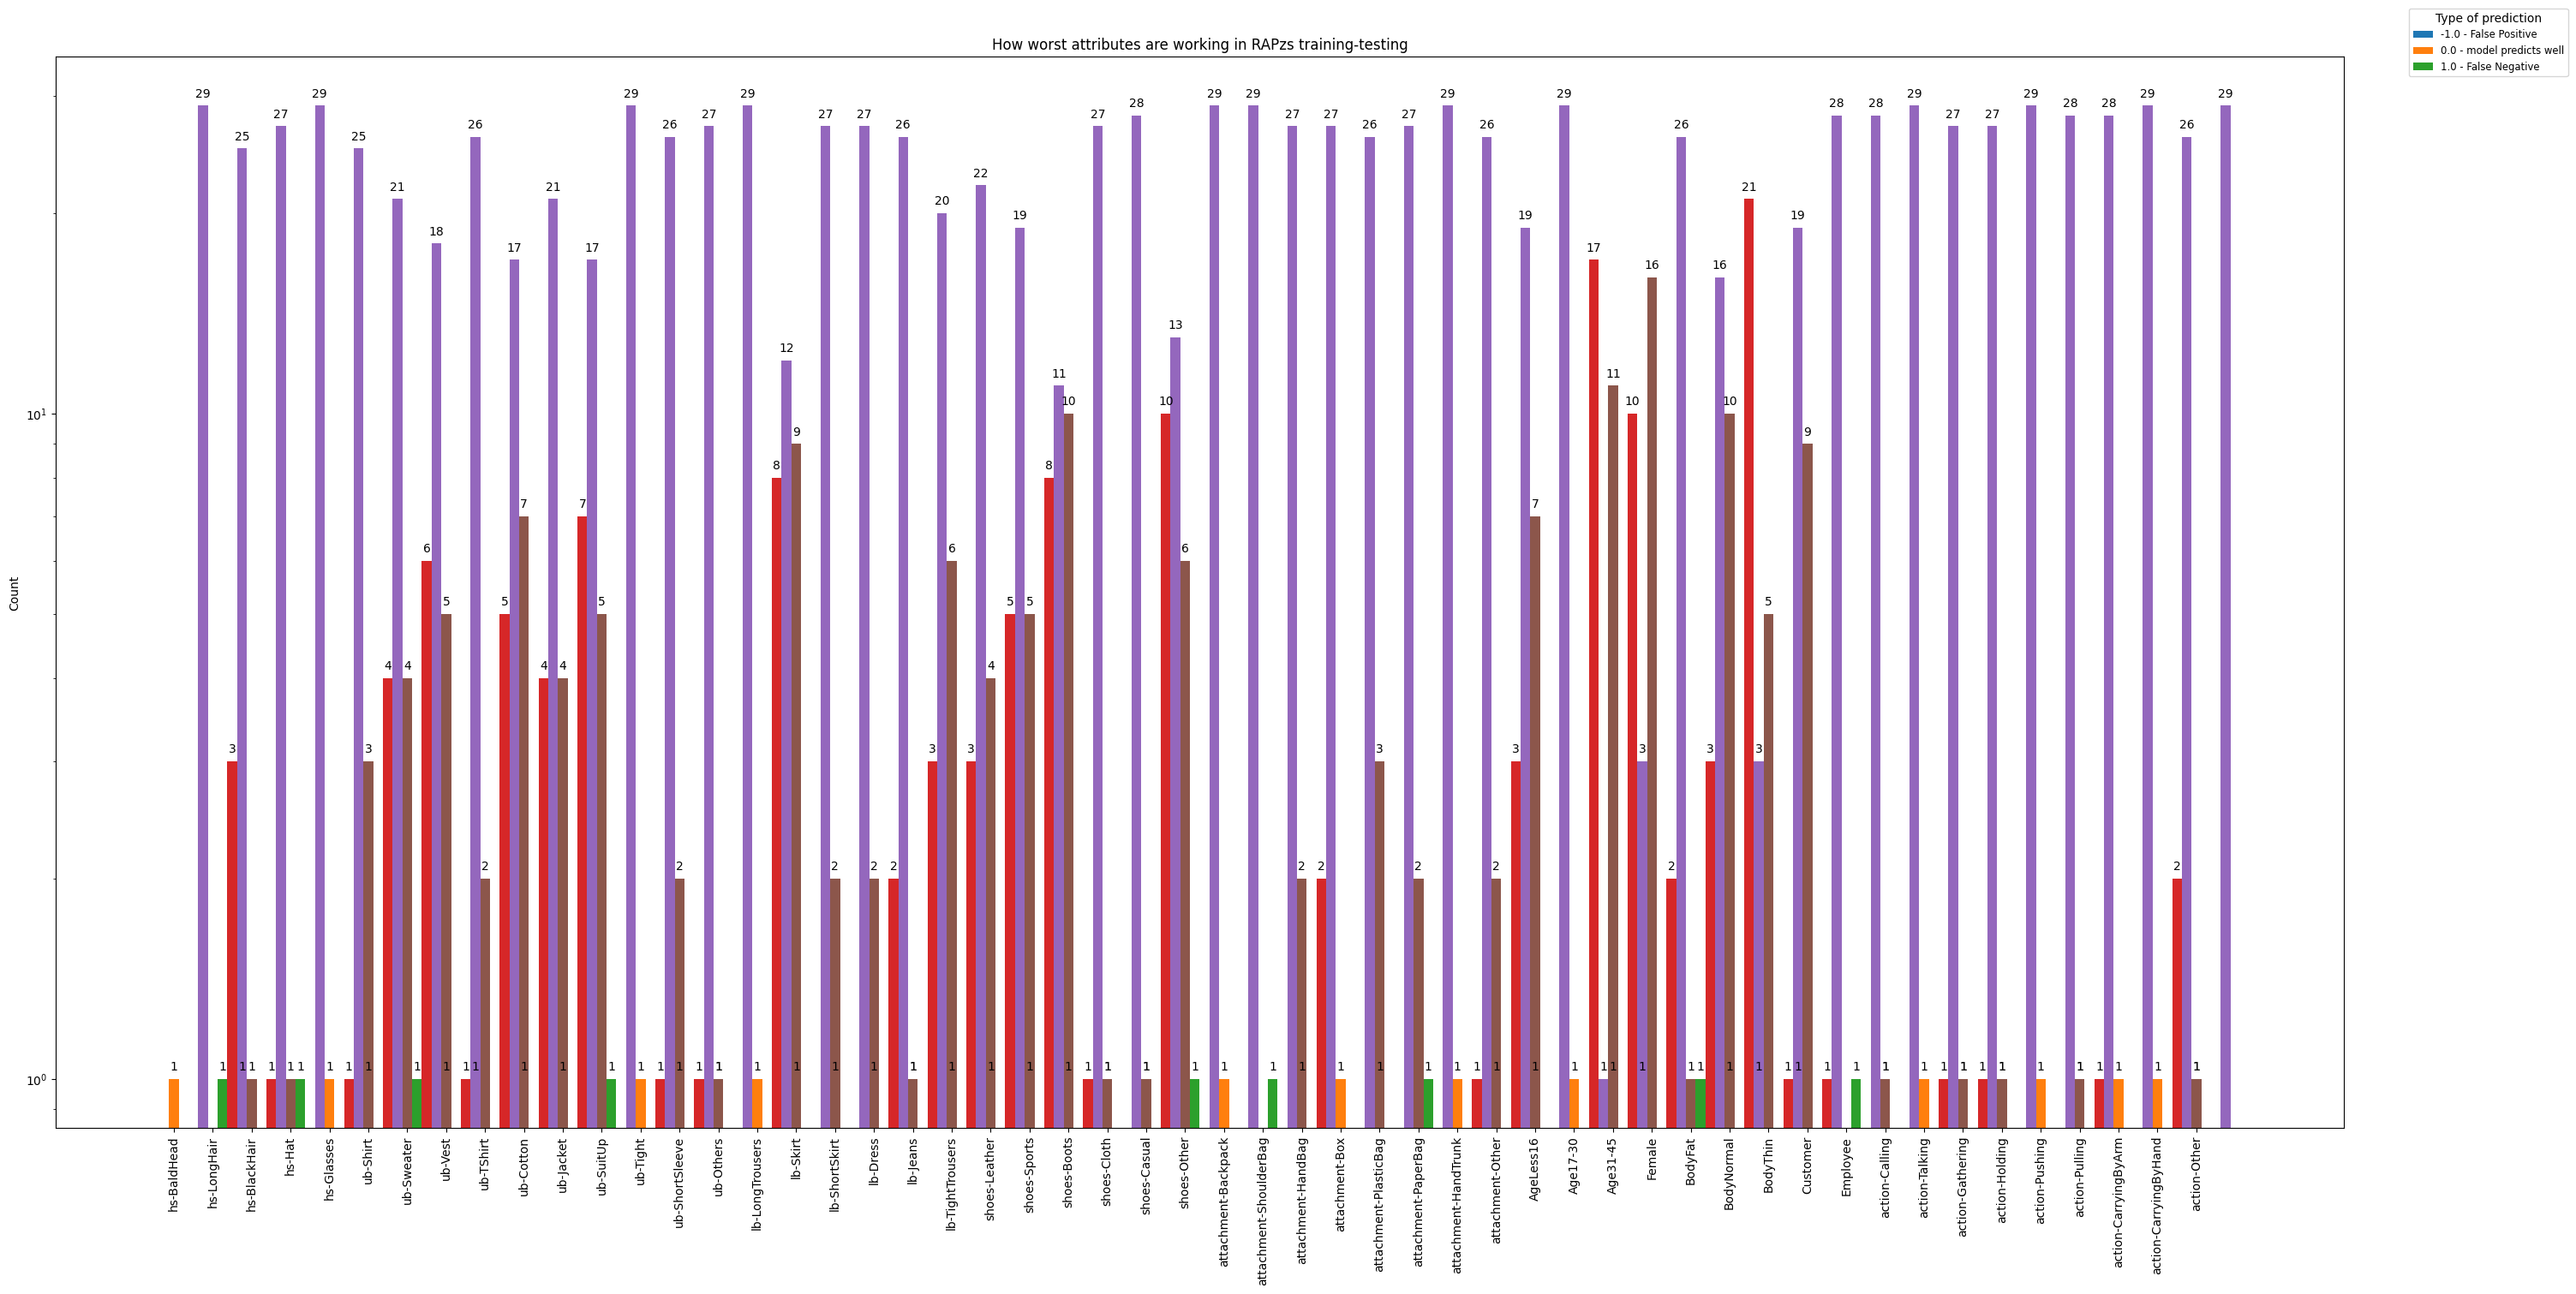

In [30]:
#dfAppearsTrainingWorst = dfTrainingWorst[listAttributesRAPzs].apply(pd.value_counts).fillna(0)
valuesAppearTrainingTestingWorst = {}
for i, row in dfAppearsTrainingWorst.iterrows():
    newI = str(i)+' training'
    valuesAppearTrainingTestingWorst[newI] = row.values.tolist()

for i, row in dfAppearsTestingWorst.iterrows():
    newI = str(i)+' testing'
    valuesAppearTrainingTestingWorst[newI] = row.values.tolist()



columns = listAttributesRAPzs
valuesAppear = valuesAppearTrainingTestingWorst
tittleGraph = 'How worst attributes are working in RAPzs training-testing'
tittleLegend = 'Type of prediction'
plotHowAttributesAreWorking(columns,valuesAppear, tittleGraph, tittleLegend)

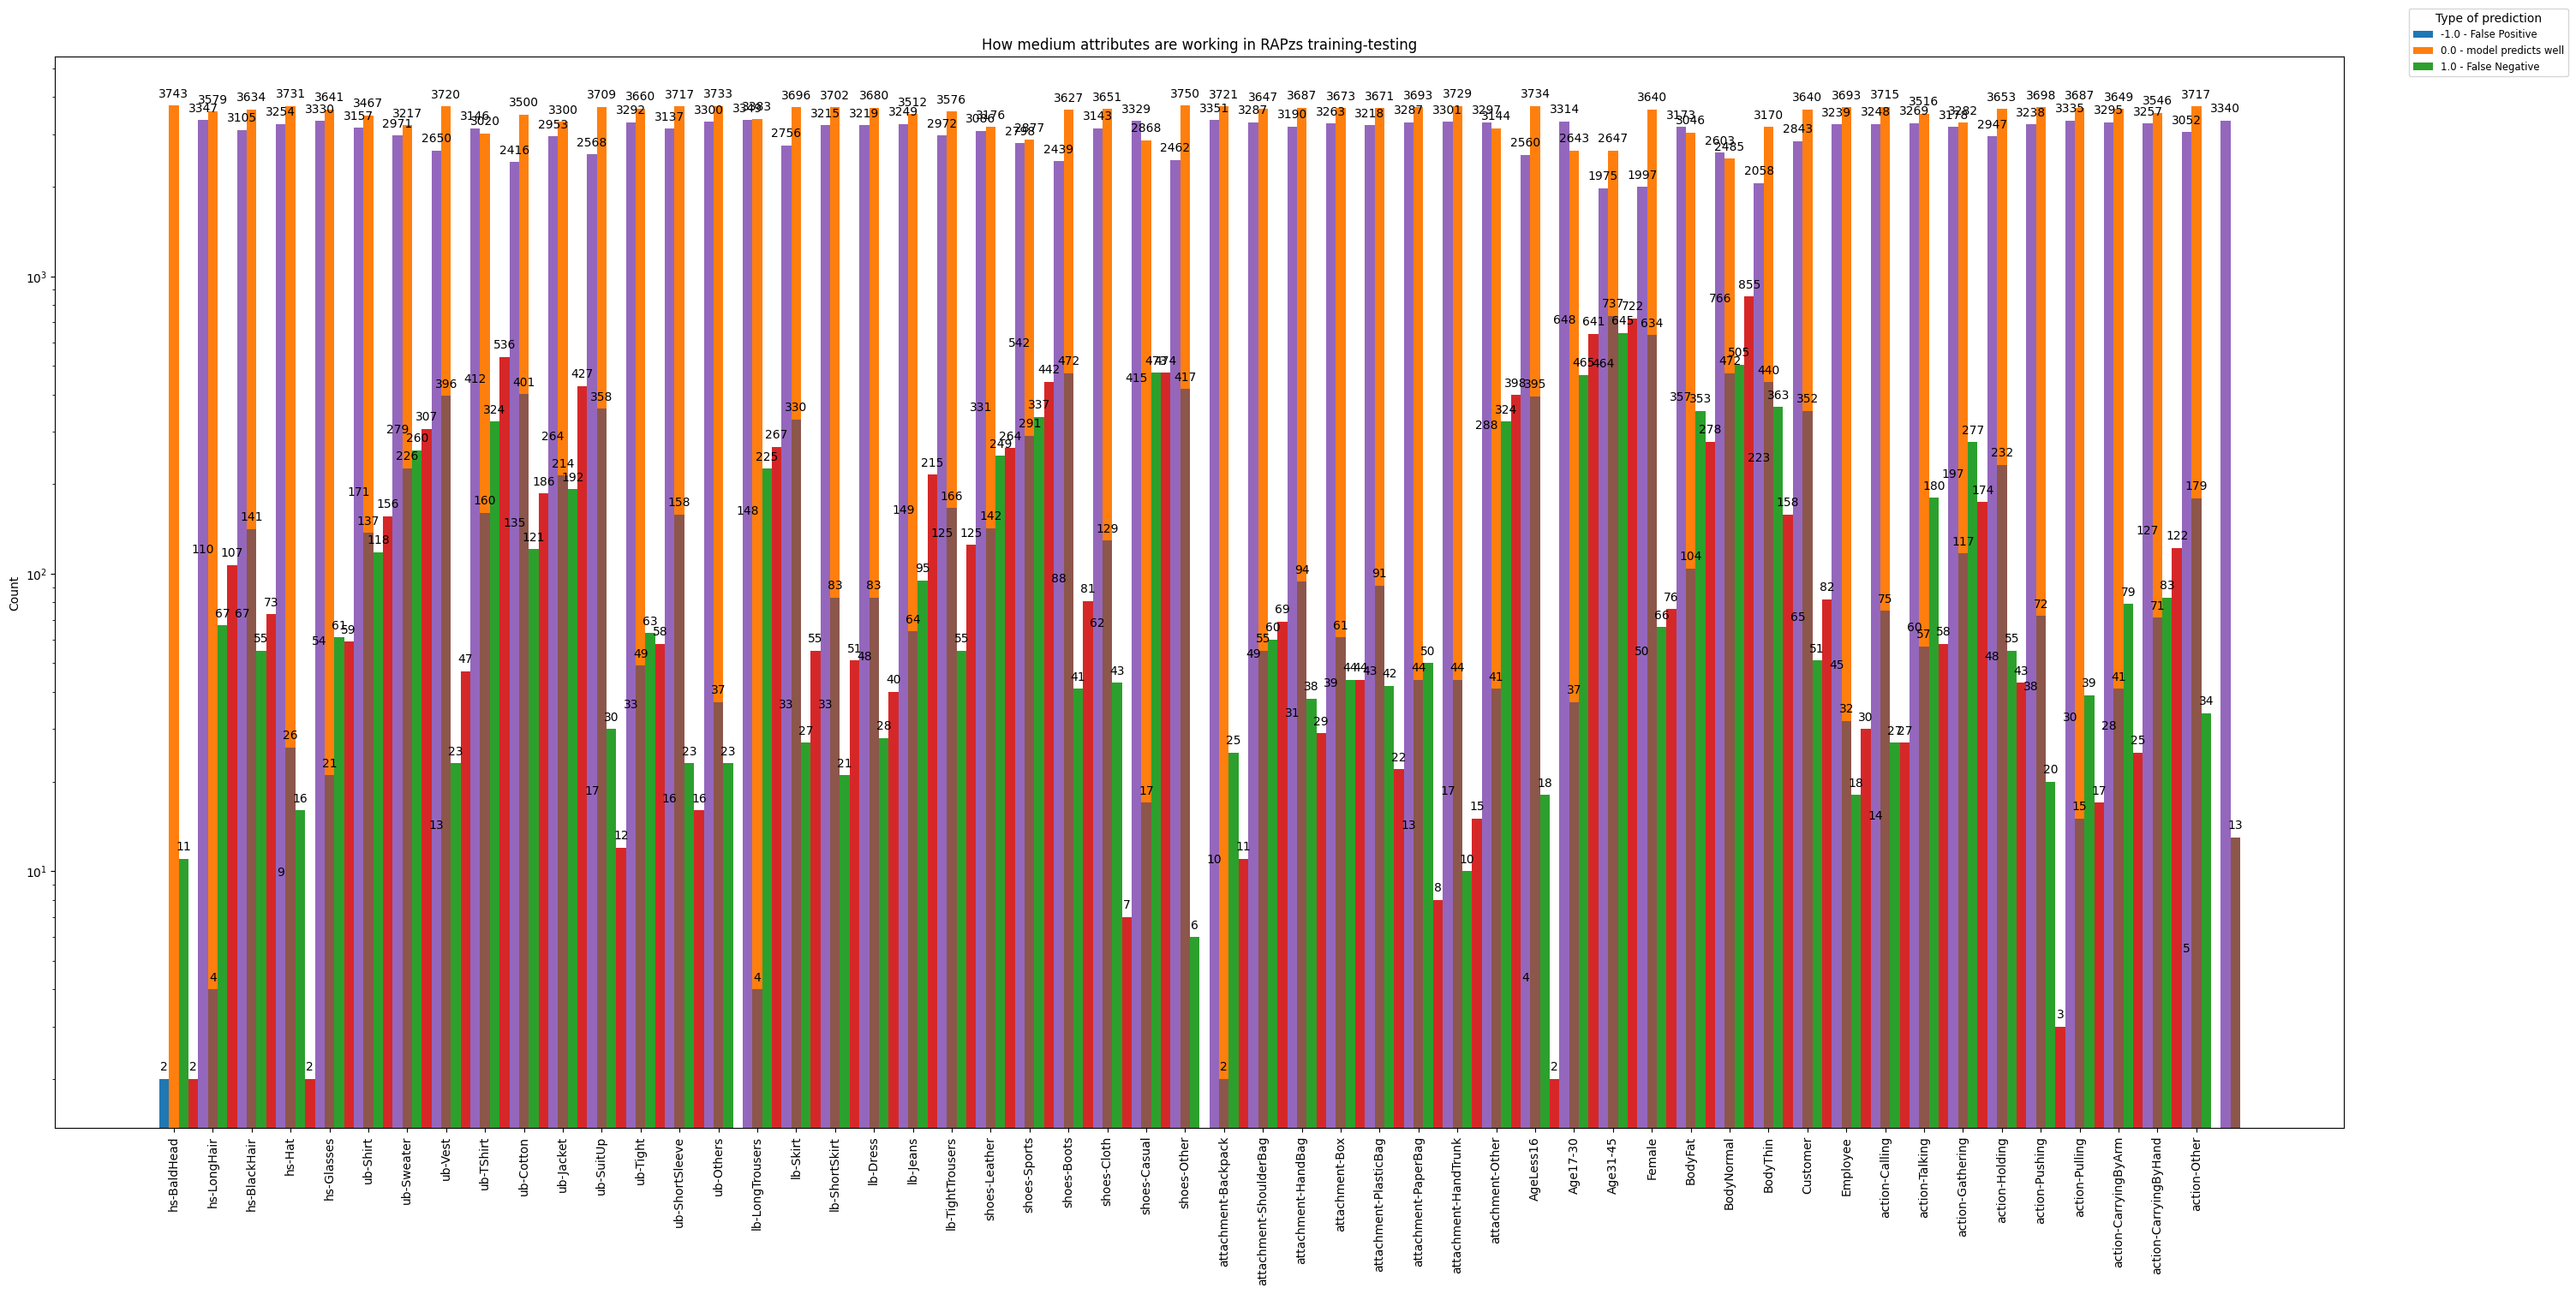

In [31]:
valuesAppearTrainingTestingMedium = {}
for i, row in dfAppearsTrainingMedium.iterrows():
    newI = str(i)+' training'
    valuesAppearTrainingTestingMedium[newI] = row.values.tolist()

for i, row in dfAppearsTestingMedium.iterrows():
    newI = str(i)+' testing'
    valuesAppearTrainingTestingMedium[newI] = row.values.tolist()


columns = listAttributesRAPzs
valuesAppear = valuesAppearTrainingTestingMedium
tittleGraph = 'How medium attributes are working in RAPzs training-testing'
tittleLegend = 'Type of prediction'
plotHowAttributesAreWorking(columns,valuesAppear, tittleGraph, tittleLegend)

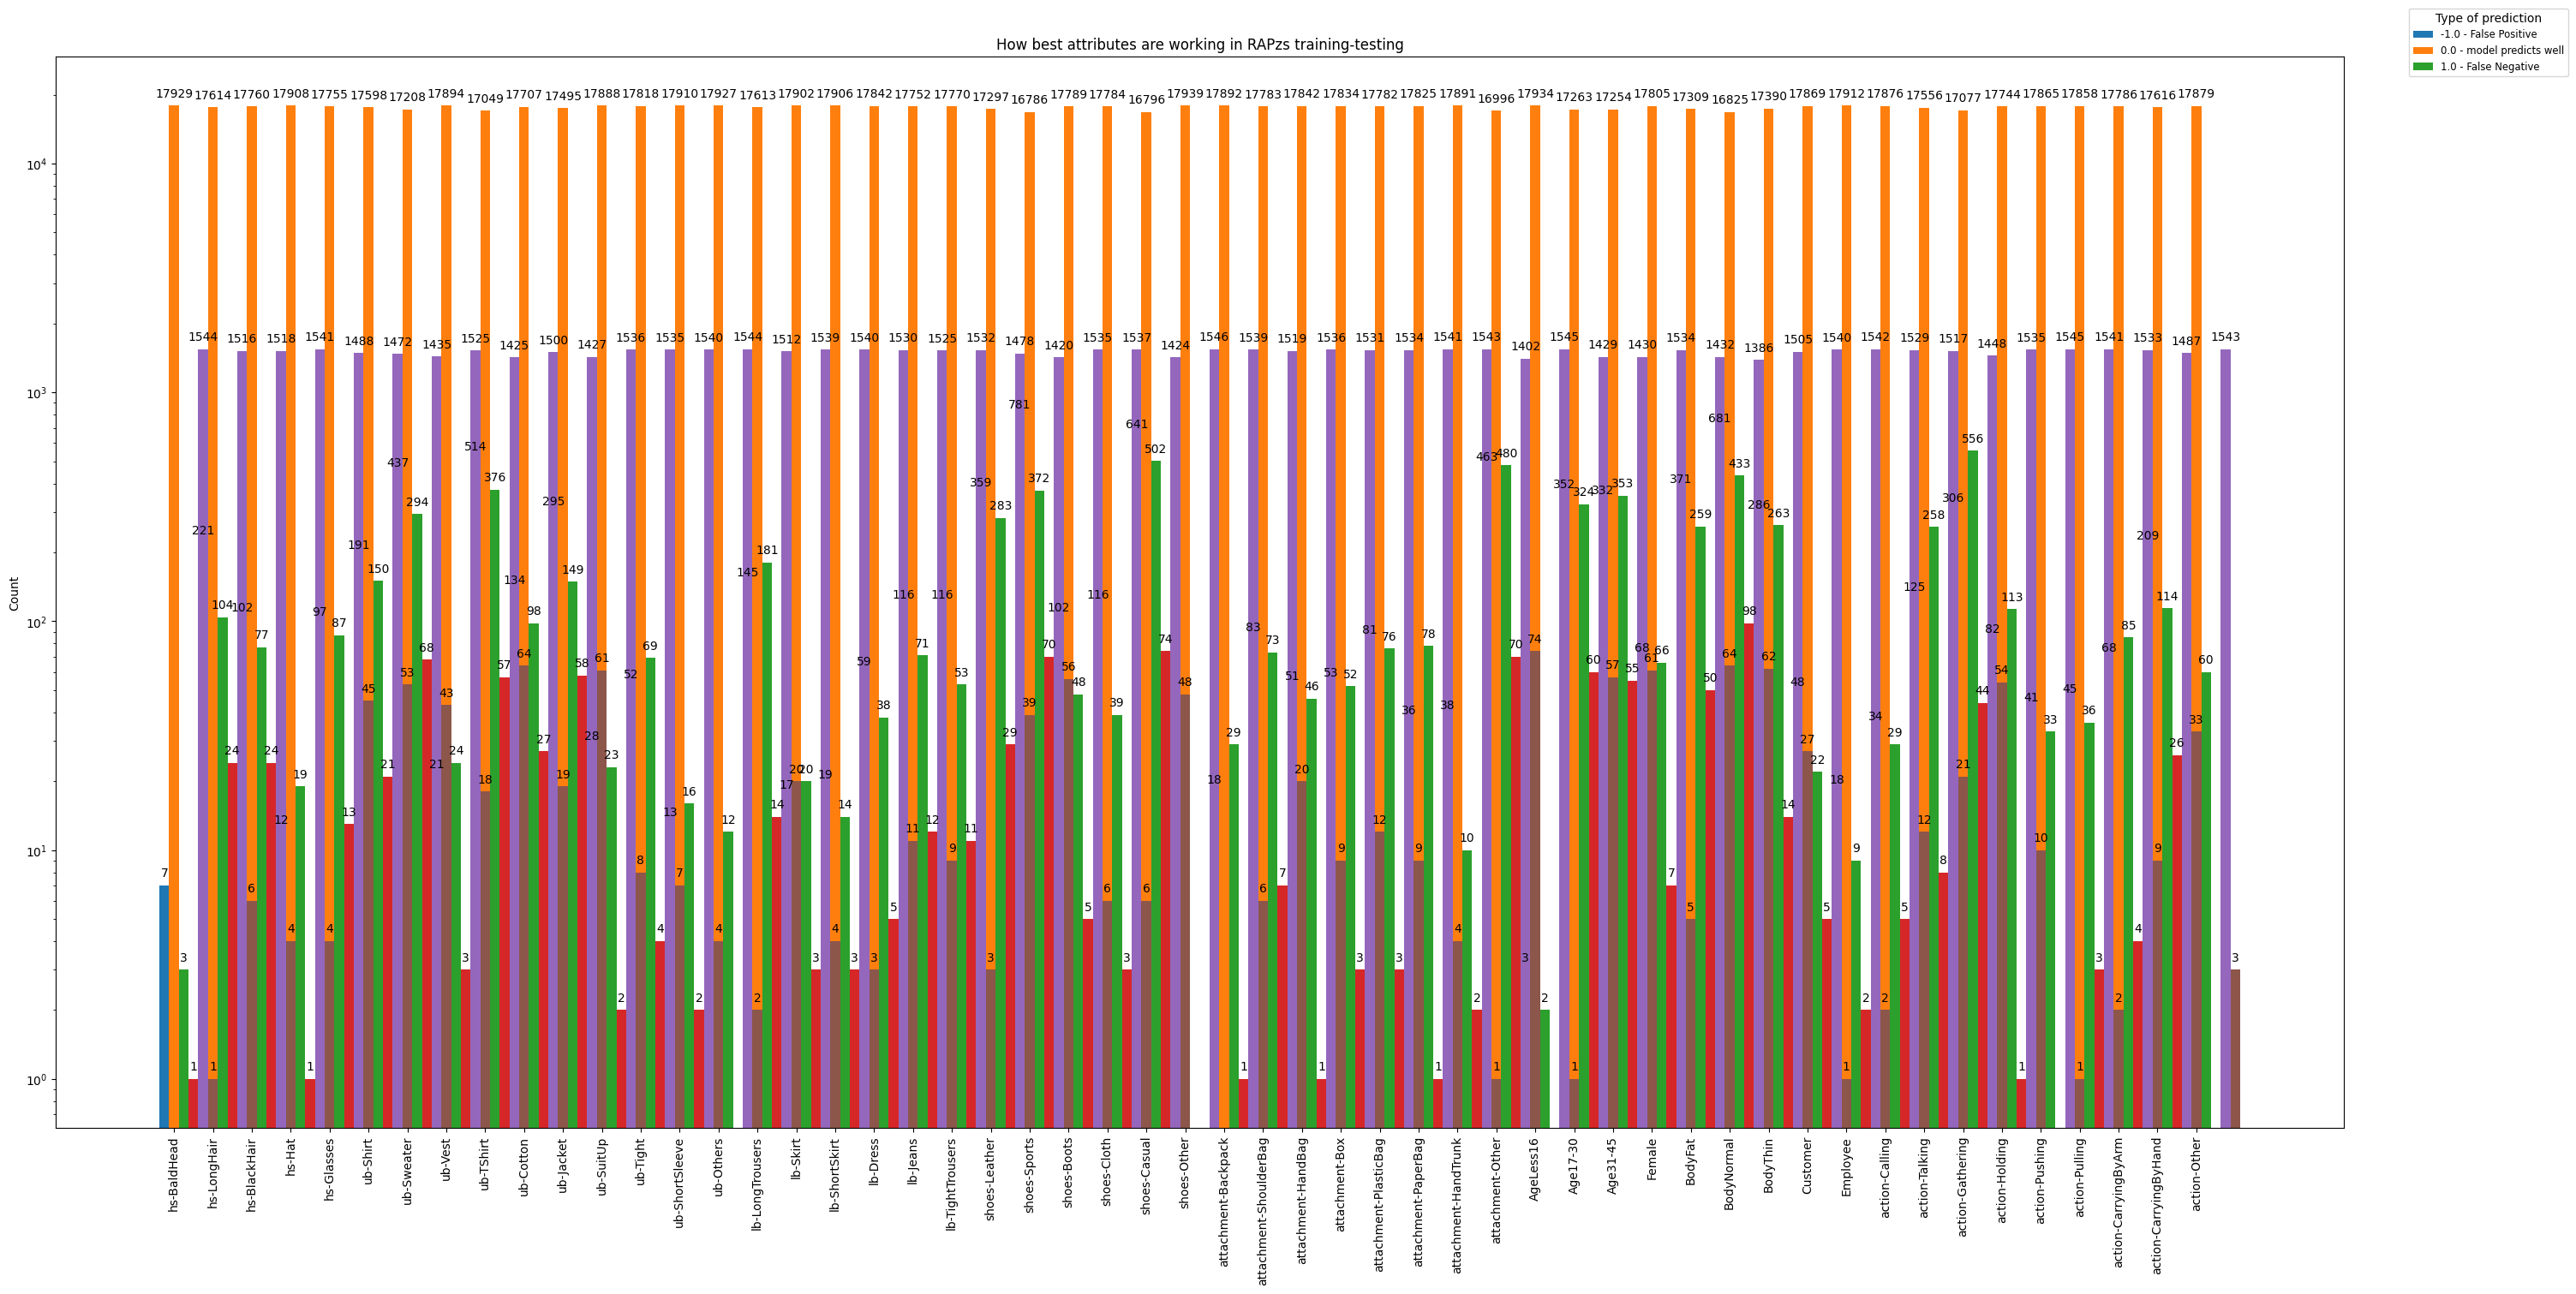

In [83]:
valuesAppearTrainingTestingBest = {}
for i, row in dfAppearsTrainingBest.iterrows():
    newI = str(i)+' training'
    valuesAppearTrainingTestingBest[newI] = row.values.tolist()

for i, row in dfAppearsTestingBest.iterrows():
    newI = str(i)+' testing'
    valuesAppearTrainingTestingBest[newI] = row.values.tolist()


columns = listAttributesRAPzs
valuesAppear = valuesAppearTrainingTestingBest
tittleGraph = 'How best attributes are working in RAPzs training-testing'
tittleLegend = 'Type of prediction'
plotHowAttributesAreWorking(columns,valuesAppear, tittleGraph, tittleLegend)

In [34]:
valuesAppearTrainingTestingBest.keys()

dict_keys(['-1.0 training', '0.0 training', '1.0 training', '-1.0 testing', '0.0 testing', '1.0 testing'])

In [67]:
import matplotlib.pyplot as plt


[   0   20   40   60   80  100  120  140  160  180  200  220  240  260
  280  300  320  340  360  380  400  420  440  460  480  500  520  540
  560  580  600  620  640  660  680  700  720  740  760  780  800  820
  840  860  880  900  920  940  960  980 1000 1020 1040]
[5, 25, 45, 65, 85, 105, 125, 145, 165, 185, 205, 225, 245, 265, 285, 305, 325, 345, 365, 385, 405, 425, 445, 465, 485, 505, 525, 545, 565, 585, 605, 625, 645, 665, 685, 705, 725, 745, 765, 785, 805, 825, 845, 865, 885, 905, 925, 945, 965, 985, 1005, 1025, 1045]
[10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490, 510, 530, 550, 570, 590, 610, 630, 650, 670, 690, 710, 730, 750, 770, 790, 810, 830, 850, 870, 890, 910, 930, 950, 970, 990, 1010, 1030, 1050]
[15, 35, 55, 75, 95, 115, 135, 155, 175, 195, 215, 235, 255, 275, 295, 315, 335, 355, 375, 395, 415, 435, 455, 475, 495, 515, 535, 555, 575, 595, 615, 635, 655, 675, 695, 715, 735, 755, 775, 795, 815, 83

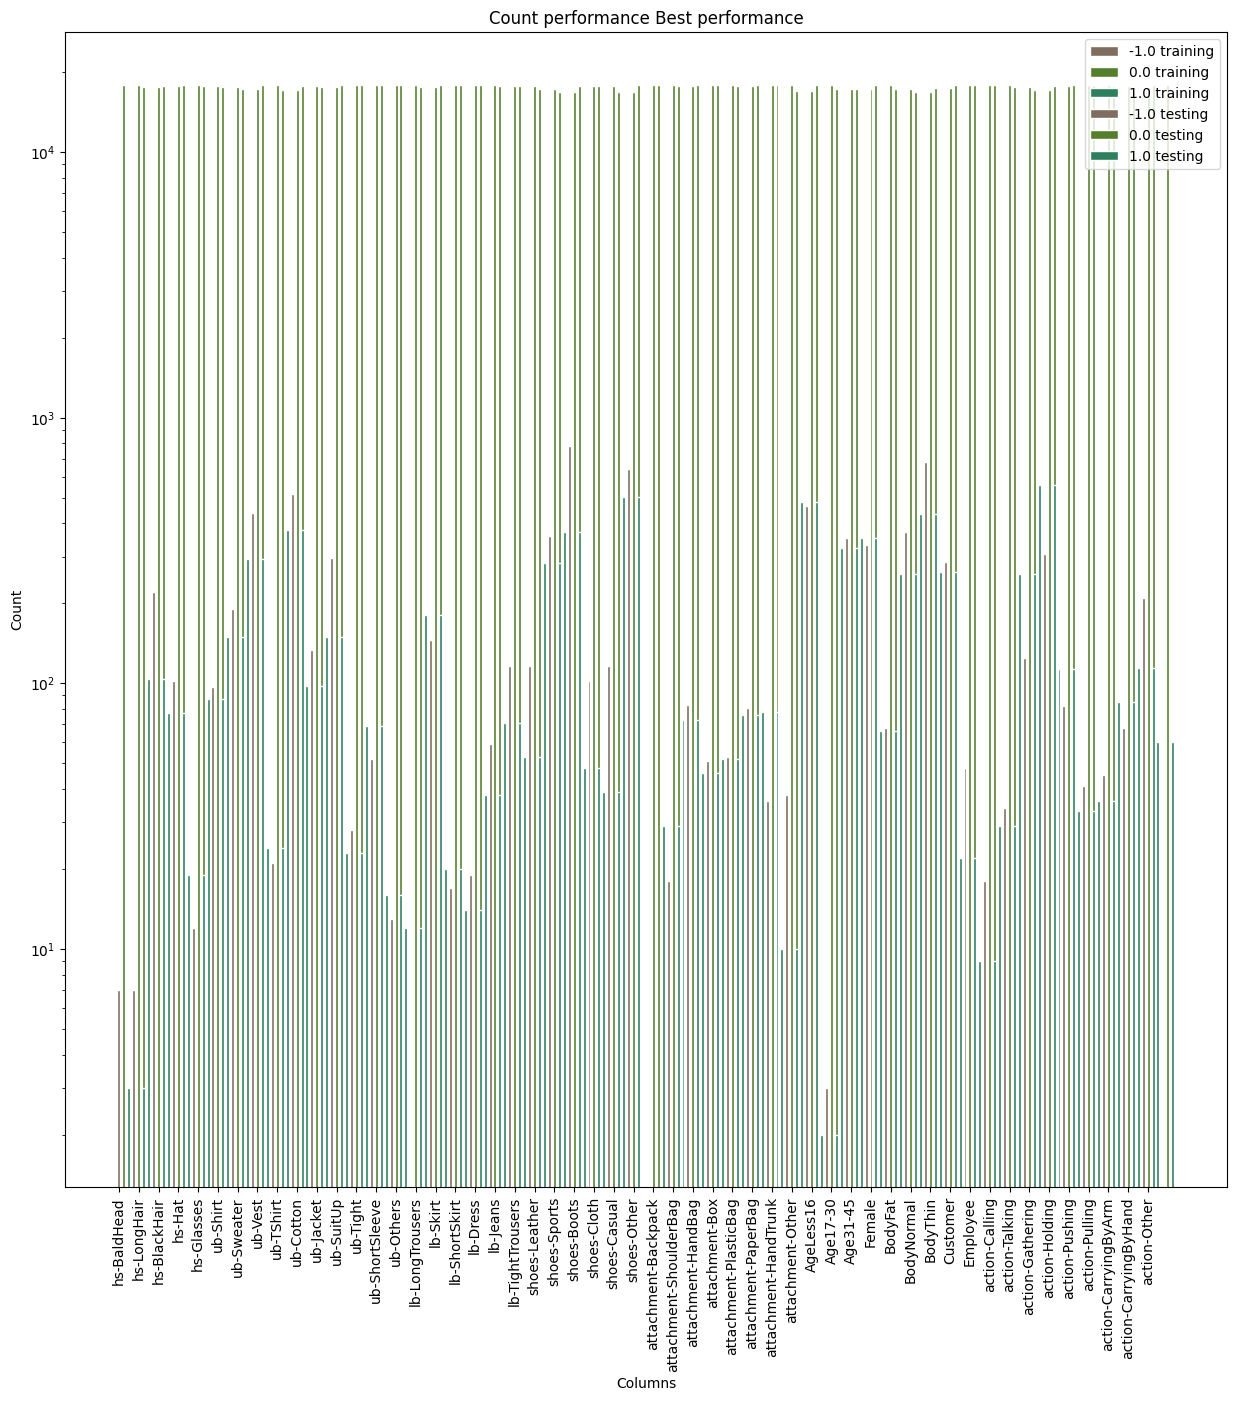

In [76]:
# Set the width of the bars
barWidth = 3
space = 2
lengthcolumn = 20
# Set the position of the bars on the x-axis
r1 = np.arange(0, len(listAttributesRAPzs)*lengthcolumn, lengthcolumn)
r2 = [x + barWidth + space for x in r1]
r3 = [x + barWidth + space  for x in r2]
r4 = [x + barWidth + space  for x in r3]
r5 = [x + barWidth + space  for x in r4]
r6 = [x + barWidth + space  for x in r5]

import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15, 15))

# Create the bar plots
plt.bar(r1, valuesAppearTrainingTestingBest['-1.0 training'], color='#7f6d5f', width=barWidth, edgecolor='white', label='-1.0 training', log=True)
plt.bar(r2, valuesAppearTrainingTestingBest['0.0 training'], color='#557f2d', width=barWidth, edgecolor='white', label='0.0 training', log=True)
plt.bar(r3, valuesAppearTrainingTestingBest['1.0 training'], color='#2d7f5e', width=barWidth, edgecolor='white', label='1.0 training', log=True)

# Create the bar plots
plt.bar(r4, valuesAppearTrainingTestingBest['-1.0 testing'], color='#7f6d5f', width=barWidth, edgecolor='white', label='-1.0 testing', log=True)
plt.bar(r5, valuesAppearTrainingTestingBest['0.0 testing'], color='#557f2d', width=barWidth, edgecolor='white', label='0.0 testing', log=True)
plt.bar(r6, valuesAppearTrainingTestingBest['1.0 testing'], color='#2d7f5e', width=barWidth, edgecolor='white', label='1.0 testing', log=True)


print(r1)
print(r2)
print(r3)
print(r4)
print(r5)
print(r6)
xticks = [x for x in r1]

# Add x-axis and y-axis labels and a title
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Count performance Best performance')

plt.xticks(xticks, listAttributesRAPzs, rotation='vertical')

# Add legend
plt.legend()

# Show the chart
plt.show()

In [97]:
dfTrainingTestingWorst = pd.DataFrame.from_dict(valuesAppearTrainingTestingWorst)
dfTrainingTestingMedium = pd.DataFrame.from_dict(valuesAppearTrainingTestingMedium)
dfTrainingTestingBest = pd.DataFrame.from_dict(valuesAppearTrainingTestingBest)

dfTrainingTestingWorst['columns'] = listAttributesRAPzs
dfTrainingTestingMedium['columns'] = listAttributesRAPzs
dfTrainingTestingBest['columns'] = listAttributesRAPzs

In [98]:
dfTrainingTestingWorst

,-1.0 training,0.0 training,1.0 training,-1.0 testing,0.0 testing,1.0 testing,columns
0,0.0,1.0,0.0,0.0,29.0,0.0,hs-BaldHead
1,0.0,0.0,1.0,3.0,25.0,1.0,hs-LongHair
2,1.0,0.0,0.0,1.0,27.0,1.0,hs-BlackHair
3,0.0,0.0,1.0,0.0,29.0,0.0,hs-Hat
4,0.0,1.0,0.0,1.0,25.0,3.0,hs-Glasses
5,0.0,1.0,0.0,4.0,21.0,4.0,ub-Shirt
6,0.0,0.0,1.0,6.0,18.0,5.0,ub-Sweater
7,0.0,1.0,0.0,1.0,26.0,2.0,ub-Vest
8,1.0,0.0,0.0,5.0,17.0,7.0,ub-TShirt
9,0.0,1.0,0.0,4.0,21.0,4.0,ub-Cotton


In [99]:
dfTrainingTestingWorst.to_csv(pathToSaveComplexIdentities+'complexIdentitiesAttributeComparationTestingTrainingWorst.csv')

In [100]:
dfTrainingTestingMedium

,-1.0 training,0.0 training,1.0 training,-1.0 testing,0.0 testing,1.0 testing,columns
0,2.0,3743.0,11.0,2.0,3347.0,4.0,hs-BaldHead
1,110.0,3579.0,67.0,107.0,3105.0,141.0,hs-LongHair
2,67.0,3634.0,55.0,73.0,3254.0,26.0,hs-BlackHair
3,9.0,3731.0,16.0,2.0,3330.0,21.0,hs-Hat
4,54.0,3641.0,61.0,59.0,3157.0,137.0,hs-Glasses
5,171.0,3467.0,118.0,156.0,2971.0,226.0,ub-Shirt
6,279.0,3217.0,260.0,307.0,2650.0,396.0,ub-Sweater
7,13.0,3720.0,23.0,47.0,3146.0,160.0,ub-Vest
8,412.0,3020.0,324.0,536.0,2416.0,401.0,ub-TShirt
9,135.0,3500.0,121.0,186.0,2953.0,214.0,ub-Cotton


In [101]:
dfTrainingTestingMedium.to_csv(pathToSaveComplexIdentities+'complexIdentitiesAttributeComparationTestingTrainingMedium.csv')

In [102]:
dfTrainingTestingBest

,-1.0 training,0.0 training,1.0 training,-1.0 testing,0.0 testing,1.0 testing,columns
0,7.0,17929.0,3.0,1.0,1544.0,1.0,hs-BaldHead
1,221.0,17614.0,104.0,24.0,1516.0,6.0,hs-LongHair
2,102.0,17760.0,77.0,24.0,1518.0,4.0,hs-BlackHair
3,12.0,17908.0,19.0,1.0,1541.0,4.0,hs-Hat
4,97.0,17755.0,87.0,13.0,1488.0,45.0,hs-Glasses
5,191.0,17598.0,150.0,21.0,1472.0,53.0,ub-Shirt
6,437.0,17208.0,294.0,68.0,1435.0,43.0,ub-Sweater
7,21.0,17894.0,24.0,3.0,1525.0,18.0,ub-Vest
8,514.0,17049.0,376.0,57.0,1425.0,64.0,ub-TShirt
9,134.0,17707.0,98.0,27.0,1500.0,19.0,ub-Cotton


In [103]:
dfTrainingTestingBest.to_csv(pathToSaveComplexIdentities+'complexIdentitiesAttributeComparationTestingTrainingBest.csv')

In [8]:
plt.hist(dfTrainingRAPzs['values'],alpha=0.75, label='Training hist')
plt.hist(dfTestingRAPzs['values'],alpha=0.75, label='Testing hist')
plt.xlabel('Performance (F1)')
plt.ylabel('Count identities with that performance')
tittle='Histogram RAPzs performance'
plt.legend(bbox_to_anchor=(1.1, 1.05), title=tittle, fontsize='small', fancybox=True)
plt.show()
plt.savefig(pathToSaveComplexIdentities+'plotHistogramTrainingTestingIdentities.pdf')

NameError: name 'dfTrainingRAPzs' is not defined

In [10]:
import numpy as np
from matplotlib.pyplot import cm
def plotComplexIdentitiesTrainingvsTesting(df, type):
    
    color = iter(cm.rainbow(np.linspace(0, 1, df['columns'].count())))

    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    for attribute in df['columns']:
        
        alpha_training = 0.4
        x_training=int(df[df['columns']==attribute]['-1.0 training'])
        y_training=int(df[df['columns']==attribute]['0.0 training'])
        z_training=int(df[df['columns']==attribute]['1.0 training'])
        
        alpha_testing = 0.7
        x_testing=int(df[df['columns']==attribute]['-1.0 testing'])
        y_testing=int(df[df['columns']==attribute]['0.0 testing'])
        z_testing=int(df[df['columns']==attribute]['1.0 testing'])

        c = next(color)
        ax.scatter(x_training, y_training, z_training, marker='s', c=c, alpha=alpha_training, label=attribute+' training')
        ax.scatter(x_testing, y_testing, z_testing, marker='X', c=c, alpha=alpha_testing, label=attribute+' testing')
        
        ax.plot([x_training, x_testing], [y_training, y_testing], [z_training, z_testing], color=c, alpha=0.1)

    ax.set_xlabel('False positive')
    ax.set_ylabel('True')
    ax.set_zlabel('False negative')

    tittle='RAPzs Training vs Testing performance '+type
    plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), title=tittle, fontsize='small', fancybox=True, ncol=4,handleheight=2.4, labelspacing=0.05)
    #plt.xlabel('False positive')
    #plt.ylabel('True')
    #plt.zlabel('False negative')
    plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

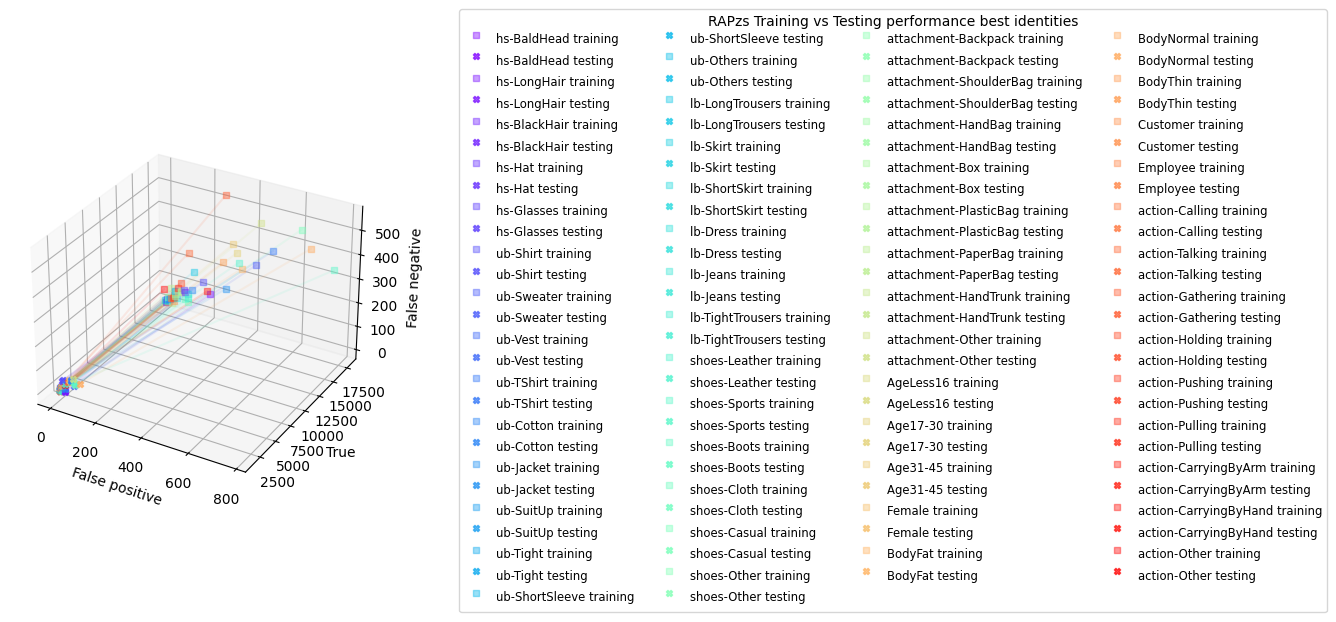

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

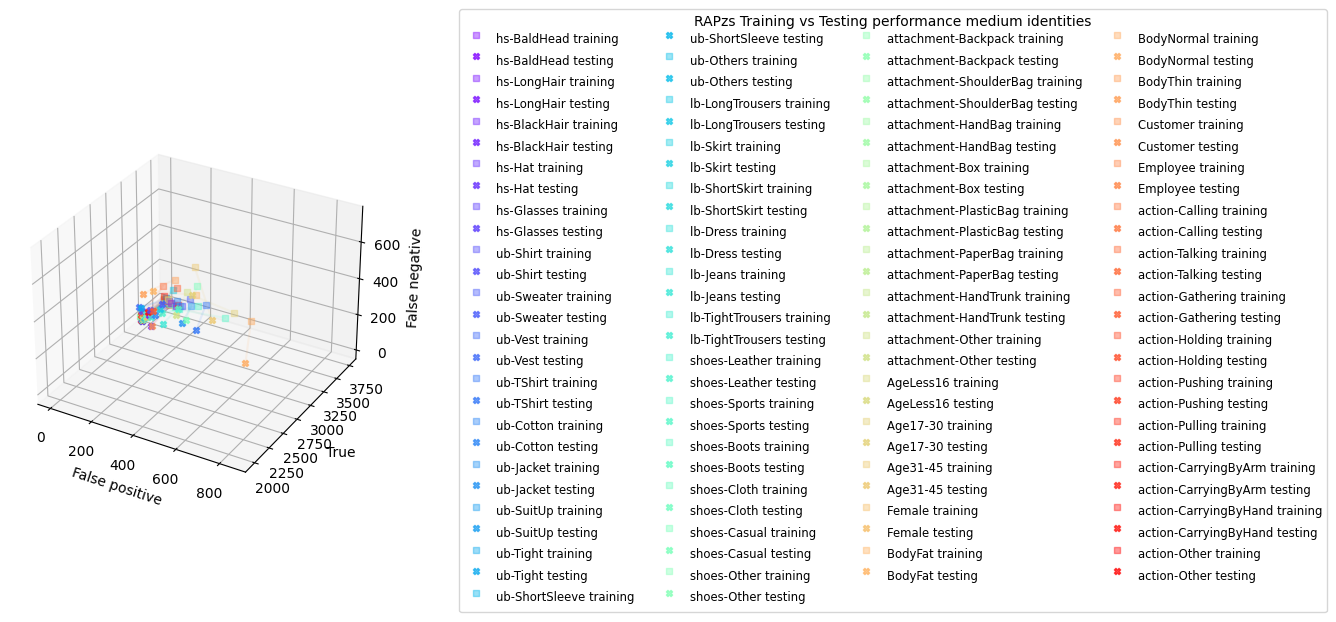

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

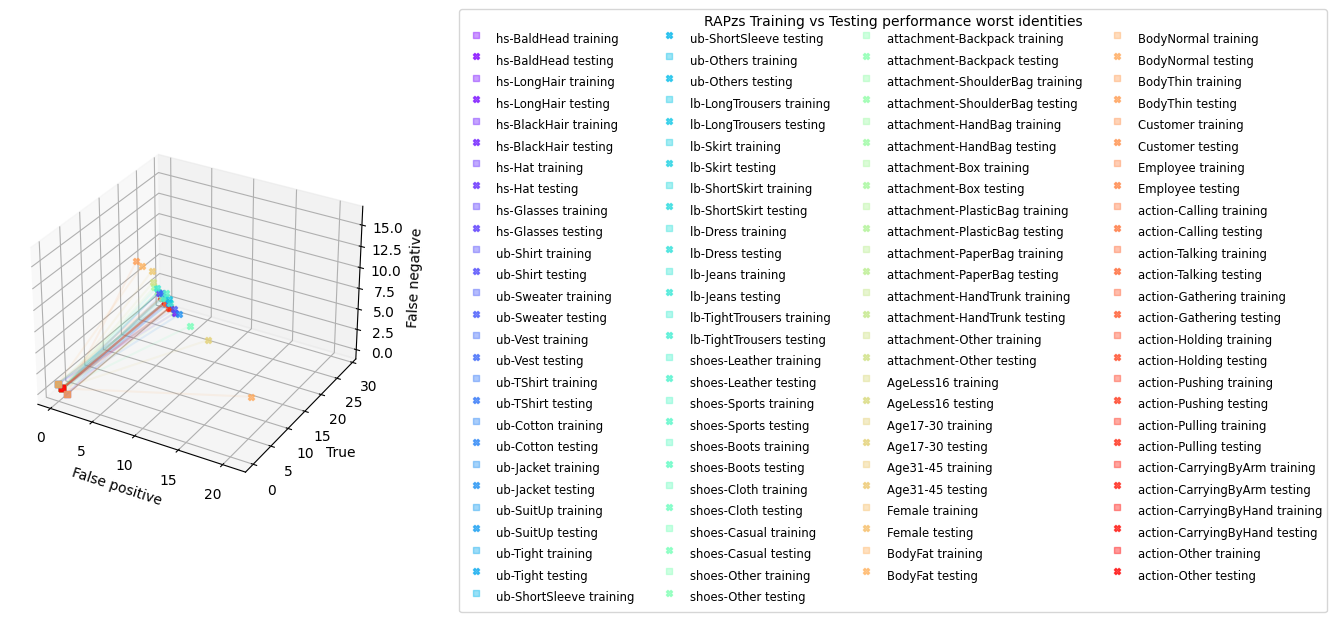

In [11]:
dfTrainingTestingBest = pd.read_csv(pathToSaveComplexIdentities+'complexIdentitiesAttributeComparationTestingTrainingBest.csv')
plotComplexIdentitiesTrainingvsTesting(dfTrainingTestingBest, 'best identities')
dfTrainingTestingMedium = pd.read_csv(pathToSaveComplexIdentities+'complexIdentitiesAttributeComparationTestingTrainingMedium.csv')
plotComplexIdentitiesTrainingvsTesting(dfTrainingTestingMedium, 'medium identities')
dfTrainingTestingWorst = pd.read_csv(pathToSaveComplexIdentities+'complexIdentitiesAttributeComparationTestingTrainingWorst.csv')
plotComplexIdentitiesTrainingvsTesting(dfTrainingTestingWorst, 'worst identities')